<a href="https://colab.research.google.com/github/skamble91/BigDL/blob/master/AI_ML_Capstone_Shweta.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Problem Definition 
 Background

AAA Northeast is one of the regional clubs comprising the American Automobile Association. AAA Northeast covers Rhode Island, Connecticut, Massachusetts and portions of New York and New Jersey. The American Automobile Association has 58 million members in the US and Canada. They offer services such as roadside assistance, maps and various discounts as part of their services. Roadside assistance is a costly benefit, particularly towing. Members who frequently use roadside assistance are less desirable.

AAA also offers other paid services at highly competitive prices. They also offer insurance, travel and banking/loan products. AAA would like to increase the penetration of these services.

A member may have a standard membership or a premium membership covering themselves and optionally additional household members. Many of AAA members typically have a long tenure with the club.

Objectives

Provide a market segmentation of AAA members (or member households) that allows AAA Northeast to better serve their members. They would use this analysis to:

    Better anticipate the needs of members
    Customize communications and offering to various segments
    Expend more effort driving acquisition and renewal of desirable members

We'll work with the members at the household level.



In [0]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import fbprophet

member_df=pd.read_csv("member_sample.csv", index_col=0)
member_df.head()
member_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21344 entries, 0 to 99998
Columns: 112 entries, Individual Key to Was Towed To AAR Referral
dtypes: float64(35), object(77)
memory usage: 18.4+ MB


# Importing data and exploring it to get insights
We have been given an excel file with 116 columns and 21000 rows. The first step would be to analyze the data for   


1.   missing values and accounting for them
2.   looking at data types and cardinality
3.   Looking at correlation
4.   Plotting different graphs

This will help us form an opinion about the data


# Missing Data


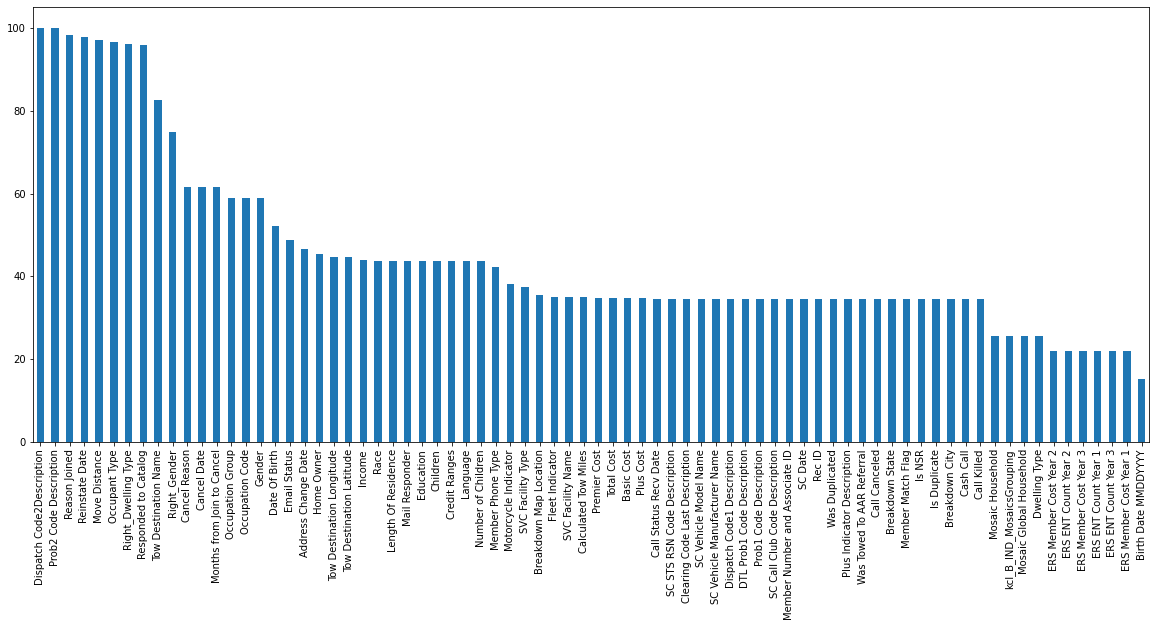

In [0]:
#underdstanding missing data using %
nulls_percent=member_df.isnull().sum()/len(member_df)*100
nulls_percent=nulls_percent[nulls_percent>2]
nulls_percent.nlargest(100).plot(kind="bar", figsize=(20,8))

You can see very quickly that there is a lot of missing values, we will tackle key variables that will be required at a later time.

It now makes sense to break down the analysis into member, record ID and household level. 

#Data Cleaning and functions
We need to deal with missing data and also build functions to deal with certain data types. Performing those functions now

In [0]:
#Missing Data cleaning

#Filling in missing date data can be done in various ways, figuring out which one to use 
member_df['Number of Children'].fillna(0, inplace=True)
member_df['Gender'].fillna('Unknown', inplace=True)
member_df['Gender'].value_counts()
member_df['Race'].fillna('Unknown ', inplace=True) #
print(member_df['Race'].value_counts())
member_df['Member Tenure Years'].dropna() # as only 1 with NA



Unknown                                   9334
Caucasion / White - European              5291
Caucasion / White - English               2931
Caucasion / White - White Non-American    1055
Caucasion / White - Unknown                461
Middle Eastern - Arab                      440
Hispanic - Hispanic Origin                 430
Caucasion / White - Eastern European       343
Unknown                                    297
Hispanic - Portuguese Origin               295
Caucasion / White - Jewish                 133
Caucasion / White - Greek                   91
Asian - Chinese                             76
American Indian                             40
African American - African Origin           32
Asian - Indian                              25
Asian - Unknown                             24
Asian - Japanese                            20
Middle Eastern - Egyptian                   12
Caucasion / White - Dutch                   10
Asian - Oriental                             4
Name: Race, d

1        49.0
2        49.0
3        49.0
4        49.0
5        49.0
         ... 
99994    54.0
99995    54.0
99996    54.0
99997    54.0
99998    54.0
Name: Member Tenure Years, Length: 21343, dtype: float64

In [0]:
print(member_df['TRV Globalware Flag'].isnull().sum())
print(member_df['INS Client Flag'].isnull().sum())
print(member_df['FSV Credit Card Flag'].isnull().sum())
print(member_df['FSV Deposit Program Flag'].isnull().sum())
print(member_df['FSV Home Equity Flag'].isnull().sum())
print(member_df['FSV ID Theft Flag'].isnull().sum())
print(member_df['FSV Mortgage Flag'].isnull().sum())

0
0
0
0
0
0
0


In [0]:
#Functions
#converting all Y&N columns to 1 or 0
def y_n_to_num(x):
    if x=='Y':
        return 1
    else:
        return 0

member_df['Call Canceled']=member_df['Call Canceled'].apply(y_n_to_num)
member_df['Cash Call']=member_df['Cash Call'].apply(y_n_to_num)


#product mapping
fsvs= [i for i in member_df.columns if i.startswith('FSV')]
for col in fsvs:
    member_df[col]=member_df[col].apply(y_n_to_num)
#other product mapping
member_df['INS Client Flag']=member_df['INS Client Flag'].apply(y_n_to_num)
member_df['TRV Globalware Flag']=member_df['TRV Globalware Flag'].apply(y_n_to_num)


#Converting income into quantative variable for future analysis
 
def mean_income(income):
  income_str=str(income)
  if income_str.endswith('9'):
    min_inc, max_inc=income_str.replace(',','').split('-')
    mean_inc=(int(min_inc)+int(max_inc))/2
    return mean_inc
  elif income=='250K+':
    return 250000
  elif income=='Under 10K':
    return 10000
  else: return 58311.510927 #took the mean of the whole column to fill in NAs

member_df['Income Mean']= member_df['Income'].apply(mean_income)

#Building revenue value
member_df['Plus Indicator Description'].value_counts()
def membership_rev(x):
  if x=='Basic Membership':
    return 54
  elif x=='Plus Membership':
    return 89
  elif x=='Premier Membership':
    return 119
  else: return 89

member_df['Membership Price']=member_df['Plus Indicator Description'].apply(membership_rev)
member_df['Membership Price'].value_counts()

#converting credit ranges to less cardinality buckets
member_df['Credit Ranges'].value_counts()
def credit_bucket(ranges):
  if ranges== '750-799':
    return 3
  elif ranges=='650-699' or ranges=='700-749':
    return 2
  elif ranges=='600-649' or ranges =='550-599':
    return 1
  elif ranges== '500-549' or ranges =='499 & Less':
    return 0
  elif ranges=='800+':
    return 4
  else: return np.nan

member_df['Credit Bucket']=member_df['Credit Ranges'].apply(credit_bucket)
member_df['Credit Bucket'].value_counts()
member_df['Credit Bucket'].fillna((member_df['Credit Bucket'].mean()), inplace=True)

def low2up_case(x):
  return str(x).upper()

member_df['SC Vehicle Manufacturer Name']=member_df['SC Vehicle Manufacturer Name'].apply(low2up_case)
member_df['SC Vehicle Model Name']=member_df['SC Vehicle Model Name'].apply(low2up_case)


#dealing with dates
#looking at date of birth .. looking at nulls and calculating age
from datetime import date
member_df['Birth Date MMDDYYYY']=pd.to_datetime(member_df['Birth Date MMDDYYYY'])
def calculate_age(born):
    today = date.today()
    if type(born)==float:
      return None
    else:
      return today.year - born.year - ((today.month, today.day) < (born.month, born.day))

member_df['Age']=member_df['Birth Date MMDDYYYY'].apply(calculate_age)

#using SC date to get year, month, week
member_df['SC Date']= pd.to_datetime(member_df['SC Date'])
member_df['SC Year'], member_df['SC Month'], member_df['SC Week']=member_df['SC Date'].dt.year, member_df['SC Date'].dt.month, member_df['SC Date'].dt.week
member_df['SC Date Only']=member_df['SC Date'].dt.date

get_unique=lambda x:x.nunique()

#creating age buckets 
def age_buckets(age): 
  if age>12 and age<=18:
    return "Gen Z"
  elif age>18 and age <=39:
    return "millenials"
  elif age>39 and age <=54:
    return "Gen X"
  elif age>54 and age<=73:
    return "Baby Boomers"
  elif age>73:
    return "silent generation"
  else:
    return "data issue"

member_df['Age Buckets']=member_df['Age'].apply(age_buckets)


#looking at subset of columns we will use to create a profile 
member_df['Number of Children'].value_counts()
#member_df['Number of Children'].fillna('unknown', inplace=True)
children=member_df['Number of Children'].value_counts().index
children
num_inst= [0,1,2,3,4,5,6]
member_df['Number of Children']=member_df['Number of Children'].map({c:n for c, n in zip(children, num_inst)})

#looking into Race
import re
#def race_buckets(x):
member_df['Race Bucket']=member_df['Race'].str.extract(r'(\w+\s)')




In [0]:
member_df[['Individual Key','Household Key','Membership Price','Race Bucket', 'Age Buckets', 'Number of Children', 'Income', 'Credit Bucket', 'FSV Credit Card Flag', 'FSV CMSI Flag',
          'FSV Deposit Program Flag', 'FSV Home Equity Flag', 'FSV ID Theft Flag', 'TRV Globalware Flag', 'INS Client Flag'
          ,'Call Canceled', 'Cash Call' ]]

,Individual Key,Household Key,Membership Price,Race Bucket,Age Buckets,Number of Children,Income,Credit Bucket,FSV Credit Card Flag,FSV CMSI Flag,FSV Deposit Program Flag,FSV Home Equity Flag,FSV ID Theft Flag,TRV Globalware Flag,INS Client Flag,Call Canceled,Cash Call
0,10000003.0,10462590.0,89,Unknown,data issue,0.0,NaN,2.537858,0,0,0,0,0,0,0,0,0
1,52211550.0,4500791.0,54,Caucasion,silent generation,2.0,"30-39,999",1.000000,0,0,0,0,0,0,0,0,0
2,52211550.0,4500791.0,54,Caucasion,silent generation,2.0,"30-39,999",1.000000,0,0,0,0,0,0,0,0,0
3,52211550.0,4500791.0,54,Caucasion,silent generation,2.0,"30-39,999",1.000000,0,0,0,0,0,0,0,0,0
4,52211550.0,4500791.0,54,Caucasion,silent generation,2.0,"30-39,999",1.000000,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99994,25797262.0,20330346.0,89,Unknown,silent generation,0.0,NaN,2.537858,0,0,0,0,0,0,0,0,0
99995,25797262.0,20330346.0,89,Unknown,silent generation,0.0,NaN,2.537858,0,0,0,0,0,0,0,0,0
99996,28273400.0,8325571.0,54,Caucasion,silent generation,3.0,"90-99,999",2.000000,0,0,0,0,0,0,0,0,0
99997,28273400.0,8325571.0,54,Caucasion,silent generation,3.0,"90-99,999",2.000000,0,0,0,0,0,0,0,0,0


Analysing missing information now 

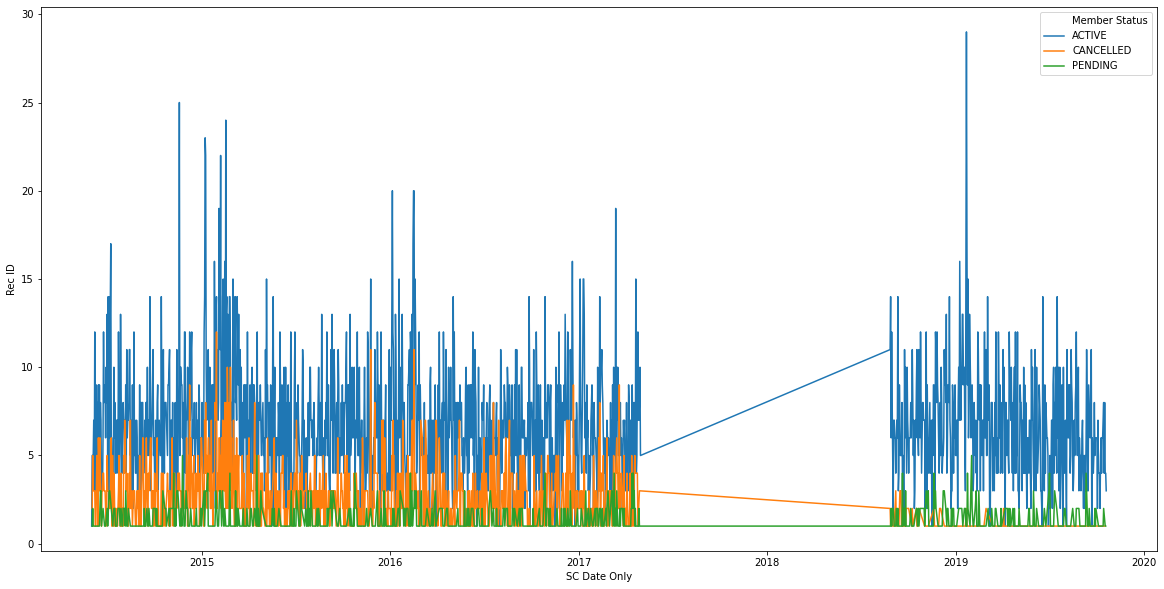

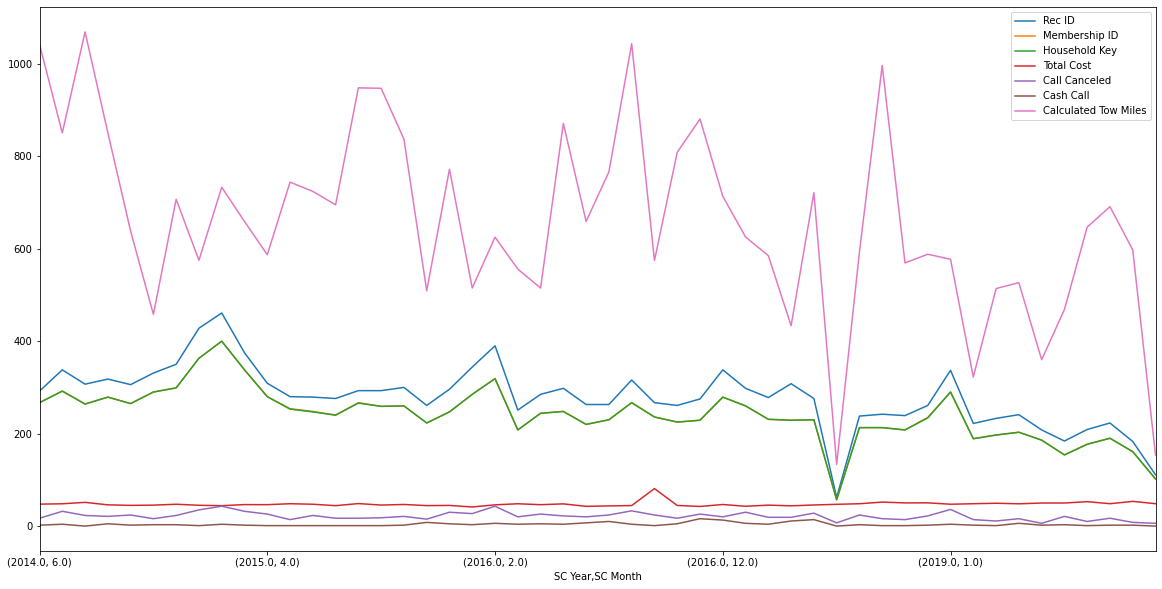

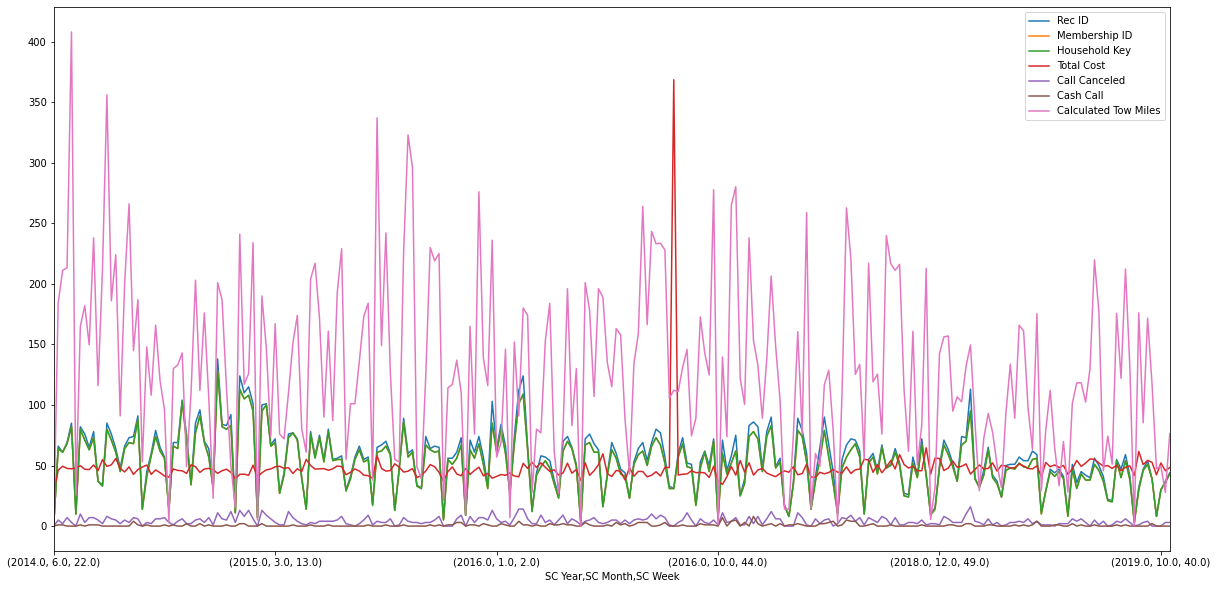

In [0]:
#Function to change 
get_unique=lambda x:x.nunique()
plt.figure(figsize=(20,10))

date_df=member_df.groupby(['SC Date Only', 'Member Status']).agg({'Rec ID':"count",'Membership ID': lambda x: x.nunique()}).reset_index()
sns.lineplot(x='SC Date Only', y='Rec ID', hue='Member Status', data=date_df)
#sns.lineplot(x='SC Year', y='Rec ID', hue='Member Status', data=member_df)
# there is gap in the data 

#looking at yearly info
member_df.groupby(['SC Year', 'SC Month']).agg({'Rec ID':"count",'Membership ID': get_unique,  'Household Key': get_unique, 'Total Cost': 'mean', 'Call Canceled': 'sum', 'Cash Call': 'sum', 'Calculated Tow Miles': "sum" }).plot(figsize=(20,10))
member_df.groupby(['SC Year', 'SC Month','SC Week']).agg({'Rec ID':"count",'Membership ID': get_unique,  'Household Key': get_unique, 'Total Cost': 'mean', 'Call Canceled': 'sum', 'Cash Call': 'sum', 'Calculated Tow Miles': "sum" }).plot(figsize=(20,10))


At the recID level and on a daily basis there seems to be a significant amount of data missing. 

The data is mising from 4th month of 2017 to 8th month of 2018. Assuming there was a system issue and we lost the data,handling for missing information

There is a huge spike in 2016 for total cost, this will skew the data and values of total cost significantly.

         count       mean        std   min    25%   50%   75%    max
SC Week                                                             
1.0       77.0  42.831169  15.734142   0.0  28.00  53.0  53.0   87.0
2.0       54.0  40.833333  16.386545   0.0  30.00  53.0  53.0   67.0
3.0       66.0  42.984848  15.111374   0.0  30.00  53.0  53.0   74.0
4.0       49.0  41.367347  19.803928   0.0  30.00  53.0  53.0  119.0
5.0       57.0  44.438596  17.223341   0.0  29.00  53.0  53.0  118.0
6.0       81.0  43.641975  15.837699   0.0  30.00  53.0  53.0   53.0
7.0      101.0  52.128713  44.698694   0.0  30.00  53.0  53.0  193.0
8.0       54.0  48.518519  32.924007   0.0  30.00  53.0  53.0  193.0
9.0       43.0  53.581395  37.213818   0.0  30.00  53.0  53.0  193.0
10.0      38.0  59.368421  41.032236  26.0  45.50  53.0  53.0  193.0
11.0      46.0  49.347826  21.916222   0.0  33.50  53.0  53.0  138.0
12.0      38.0  50.447368  27.239377  26.0  30.00  53.0  53.0  185.0
13.0      42.0  47.833333  13.9439

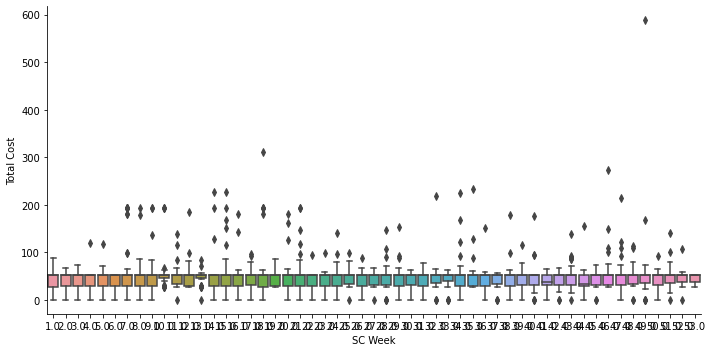

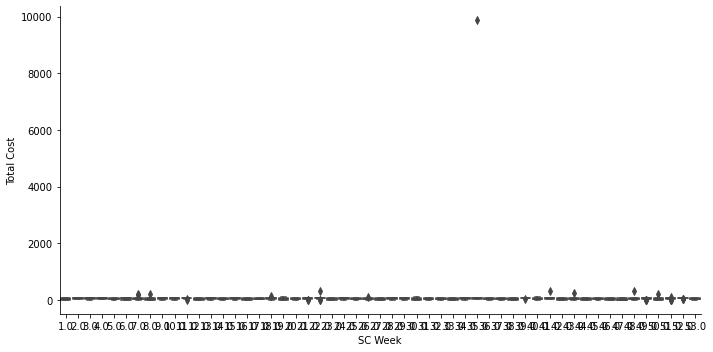

In [0]:
#looking at box plots for 2016 data




member_df_16=member_df[(member_df['SC Year']==2016) & (member_df['Member Status']!= 'CANCELLED')]
sns.catplot(x="SC Week", y="Total Cost", kind="box",aspect=2,data=member_df_16)
print(member_df_16.groupby([ 'SC Week'])['Total Cost'].describe())
member_df_16_cancelled=member_df[(member_df['SC Year']==2016) & (member_df['Member Status']== 'CANCELLED')]
print(member_df_16_cancelled.groupby([ 'SC Week'])['Total Cost'].describe())
sns.catplot(x="SC Week", y="Total Cost", kind="box",aspect=2,data=member_df_16_cancelled)
#sns.catplot(x="Age Buckets", y="Total Cost",  hue="Member Status", col="SC Year",kind="box",aspect=2,data=member_df_16_cancelled)
#outlier is coming from cancelled call
#looking into reasons cancelled

# cancel reason is at the membership level and cost structure is a little ambiguous
member_df_16_cancelled[member_df_16_cancelled['SC Week']==35.0].groupby(['Cancel Reason', 'Rec ID']).agg({'Rec ID':lambda x:x.nunique() , 'Total Cost': 'sum'})
member_df=member_df[member_df['Rec ID']!=6033663.0]





Clearly the outlier is coming from incorrect data entry, we can remove that data point

#Record ID level analysis
Record ID seems like the most granular level of data
we will like to identify first elements at record ID level, then tackle missing values for important columns

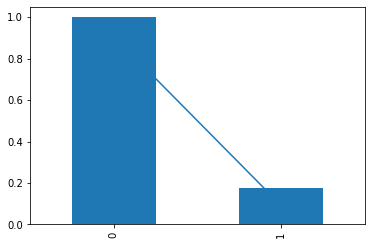

In [0]:
member_df.groupby(['Household Key','Individual Key', 'Rec ID']).count()
#exploring the first household
member_df[(member_df['Household Key']==875.0) & (member_df['Individual Key']==717785.0)].groupby(['Household Key', 'Individual Key']).nunique()
member_df[(member_df['Household Key']==875.0) & (member_df['Individual Key']==717785.0)]
member_df['TRV Globalware Flag'].value_counts(normalize=True).plot()
member_df['INS Client Flag'].value_counts(normalize=True).plot(kind='bar')
member_df['FSV Credit Card Flag'].value_counts(normalize=True).plot(kind='bar')
member_df['FSV Deposit Program Flag'].value_counts(normalize=True).plot(kind='bar')
member_df['FSV Home Equity Flag'].value_counts(normalize=True).plot(kind='bar')
member_df['FSV ID Theft Flag'].value_counts(normalize=True).plot(kind='bar')
member_df['FSV Mortgage Flag'].value_counts(normalize=True).plot(kind='bar')



Observations of the data from different slices show the columns that seem to be associated with Rec ID are: 
> Breakdown Location, Basic Cost, Calculated Tow Miles, Call Status Recv Date, Cancelled Call, Call Killed, Problem & clearing descriptions, Total Cost, towing destinations etc

Digging into dates and other related quantitative columns

In [0]:
rec_cols=['Rec ID','Individual Key', 'Basic Cost', 'Calculated Tow Miles', 'Call Status Recv Date', 'Call Canceled', 'Call Killed', 'SC Date', 'Total Cost', 'Premier Cost', 'Plus Cost']

rec_df=member_df[rec_cols]

#profile data
import pandas_profiling as pf
#pf.ProfileReport(rec_df)
member_df['Race Bucket'].value_counts()

Caucasion     10315
Unknown        9333
Hispanic        725
Middle          452
Asian           149
American         40
African          32
Name: Race Bucket, dtype: int64

In [0]:
rec_nulls=member_df[member_df['Rec ID'].isnull()]
print(member_df[member_df['Rec ID'].isnull()].count())
rec_nulls[['Individual Key','Total Cost','Basic Cost', 'ERS ENT Count Year 1','ERS ENT Count Year 2',
 'ERS ENT Count Year 3',
 'ERS Member Cost Year 1',
 'ERS Member Cost Year 2',
 'ERS Member Cost Year 3',]].count()

rec_nulls[(rec_nulls['ERS ENT Count Year 1'].isnull()) |(rec_nulls['ERS ENT Count Year 2'].isnull()) | (rec_nulls['ERS ENT Count Year 3'].isnull()) ].count() #4332
rec_nulls[(rec_nulls['ERS ENT Count Year 1'].isnull()) &(rec_nulls['ERS ENT Count Year 2'].isnull()) & (rec_nulls['ERS ENT Count Year 3'].isnull()) ].count()#4332


Individual Key     7347
Household Key      7347
Member Flag        7347
City               7347
State - Grouped    7347
                   ... 
SC Month              0
SC Week               0
SC Date Only          0
Age Buckets        7347
Race Bucket        7290
Length: 122, dtype: int64


Individual Key     4332
Household Key      4332
Member Flag        4332
City               4332
State - Grouped    4332
                   ... 
SC Month              0
SC Week               0
SC Date Only          0
Age Buckets        4332
Race Bucket        4310
Length: 122, dtype: int64

From analysis it seems like this dataset was made from 2 different tables. Rec ID level table and Membership level table. There was a full join made which has caused missing information on both ends. There are customers who do not have rec IDs 7347, this could be because there is missing data or they did not place calls and they are customers who are profitable. 

Digging into membership level now to understand this data 


#Membership Level Analysis

Based on our previous data, we saw that this data seems like a join between membership level and rec ID level. 

There are several members without calls. Trying to understand who those customers are and if it is a missing data issue



In [0]:
rec_nulls
print(rec_nulls['TRV Globalware Flag'].value_counts(normalize=True)*100)
print(rec_nulls['INS Client Flag'].value_counts(normalize=True)*100)
print(rec_nulls['FSV Credit Card Flag'].value_counts(normalize=True)*100)
print(rec_nulls['FSV Deposit Program Flag'].value_counts(normalize=True)*100)
print(rec_nulls['FSV Home Equity Flag'].value_counts(normalize=True)*100)
print(rec_nulls['FSV ID Theft Flag'].value_counts(normalize=True)*100)
print(rec_nulls['FSV Mortgage Flag'].value_counts(normalize=True)*100)	 	


no_call_member=rec_nulls[(rec_nulls['ERS ENT Count Year 1'].isnull()) &(rec_nulls['ERS ENT Count Year 2'].isnull()) & (rec_nulls['ERS ENT Count Year 3'].isnull()) ]
no_call_member['Age Buckets'].value_counts()
no_call_member['Number of Children'].value_counts()/len(no_call_member)
no_call_member['Member Tenure Years'].isnull().sum()


NameError: ignored

In [0]:
memberage=member_df.groupby(['Age Buckets', 'SC Year','Member Status'])['Rec ID'].count().reset_index()
member_df.groupby(['Age Buckets', 'SC Year','Member Status'])['Rec ID'].describe()

count  ...         max
Age Buckets       SC Year Member Status         ...            
Baby Boomers      2014.0  ACTIVE         571.0  ...  10256675.0
                          CANCELLED      108.0  ...  10180091.0
                          PENDING         75.0  ...  10130315.0
                  2015.0  ACTIVE         988.0  ...  10640306.0
                          CANCELLED      152.0  ...  10605735.0
...                                        ...  ...         ...
silent generation 2018.0  CANCELLED       22.0  ...  17329270.0
                          PENDING         36.0  ...  17436788.0
                  2019.0  ACTIVE         771.0  ...  20458524.0
                          CANCELLED       24.0  ...  20429345.0
                          PENDING         63.0  ...  20448457.0

[91 rows x 8 columns]

                                         count       mean  ...      75%     max
Age Buckets       Member Status SC Year                    ...                 
Baby Boomers      ACTIVE        2018.0   335.0  49.018119  ...  58.8500  300.00
                                2019.0   673.0  49.800015  ...  58.8500  202.85
                  CANCELLED     2018.0    21.0  57.830000  ...  58.8500  242.74
                                2019.0    11.0  42.218182  ...  58.8500   58.85
                  PENDING       2018.0    45.0  53.253333  ...  58.8500  160.85
                                2019.0    88.0  50.169659  ...  58.8500  168.56
Gen X             ACTIVE        2018.0    66.0  46.502879  ...  58.8500  124.85
                                2019.0   199.0  49.194171  ...  58.8500  247.85
                  CANCELLED     2018.0     4.0  51.637500  ...  58.8500   58.85
                                2019.0     5.0  53.180000  ...  58.8500   58.85
                  PENDING       2018.0  

<Figure size 1440x648 with 0 Axes>

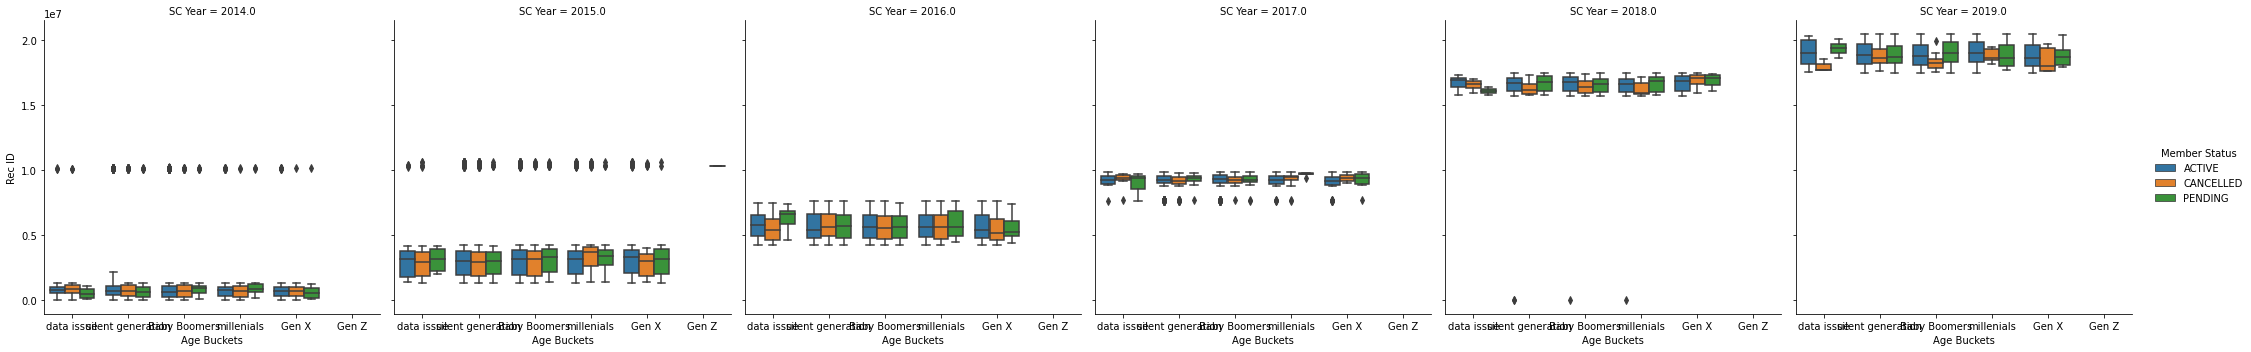

<Figure size 1800x720 with 0 Axes>

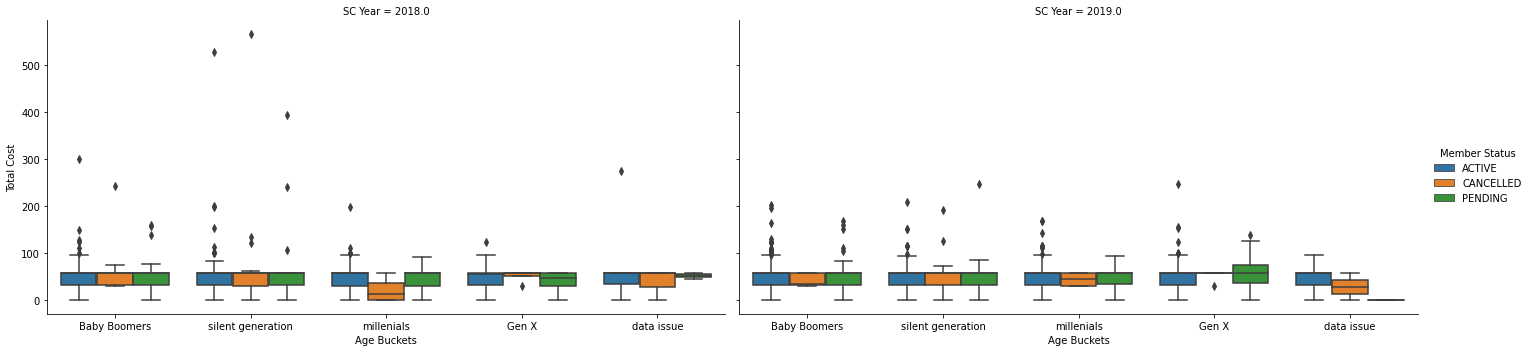

<Figure size 1440x720 with 0 Axes>

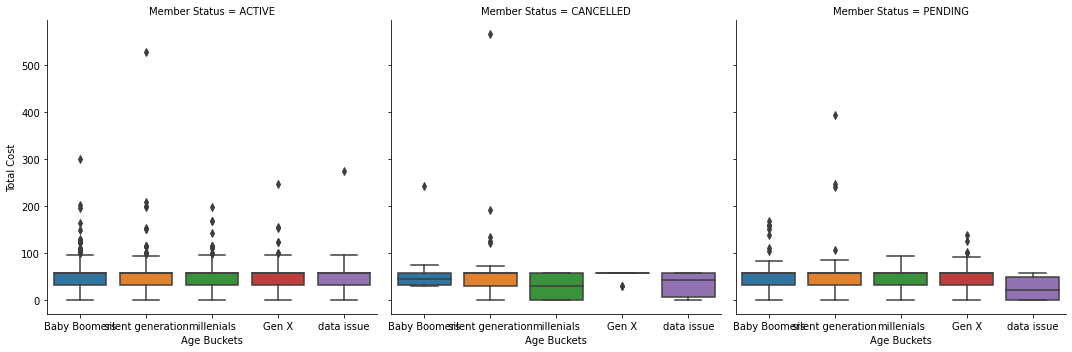

In [0]:
member_df_active=member_df.where(member_df['Member Status']=='ACTIVE')
member_df['Age Buckets'].value_counts()
plt.figure(figsize=(20,9))
memberage=member_df.groupby(['Age Buckets', 'SC Year','Member Status'])['Rec ID'].count().reset_index()
sns.catplot(x="Age Buckets", y="Rec ID",  hue="Member Status", col="SC Year",kind="box",data=member_df)
member_df.groupby('Age Buckets')['Total Cost'].describe()


member_df_1819=member_df[((member_df['SC Year']==2018) | (member_df['SC Year']==2019))]
plt.figure(figsize=(25,10))
sns.catplot(x="Age Buckets", y="Total Cost",  hue="Member Status", col="SC Year",kind="box",aspect=2,data=member_df_1819)
print(member_df_1819.groupby(['Age Buckets','Member Status', 'SC Year'])['Total Cost'].describe())



# experimenting with box plots 
plt.figure(figsize=(20,10))
sns.catplot(x="Age Buckets", y="Total Cost",  col="Member Status",kind="box", aspect=1,data=member_df_1819)



In [0]:
member_df['Motorcycle Indicator'].value_counts()

N    9381
Y    3799
Name: Motorcycle Indicator, dtype: int64

In [0]:
member_df_dummies=pd.get_dummies(member_df, columns=['SC Year','Race Bucket', 'Gender','Member Status','Motorcycle Indicator'])
member_df_dummies.columns
member_df_dummies.count()

Individual Key             21343
Household Key              21343
Member Flag                21343
City                       21343
State - Grouped            21343
                           ...  
Member Status_ACTIVE       21343
Member Status_CANCELLED    21343
Member Status_PENDING      21343
Motorcycle Indicator_N     21343
Motorcycle Indicator_Y     21343
Length: 138, dtype: int64

In [0]:

# looking at only active and pending members
active_member_df= member_df[(member_df['Member Status']=='ACTIVE') | (member_df['Member Status']=='PENDING')]

#aggregating Records of instances on member ID level
#active_member_df['SC Year'].value_counts()




member_ads=member_df_dummies.groupby(['Individual Key','Race Bucket_Caucasion ', 'Race Bucket_Hispanic ',
       'Race Bucket_Middle ', 'Race Bucket_Unknown ', 'Race Bucket_African ', 'Race Bucket_American ',
        'Race Bucket_Asian ', 'Gender_Female',
       'Gender_Male', 'Gender_Unknown', 'Member Status_ACTIVE',
       'Member Status_CANCELLED', 'Member Status_PENDING','FSV CMSI Flag', 
       'FSV Credit Card Flag','FSV Deposit Program Flag',  'FSV Home Equity Flag',
       'FSV ID Theft Flag', 'FSV Mortgage Flag','TRV Globalware Flag','INS Client Flag',
       'SC Year_2018.0', 'SC Year_2019.0'	]).agg({'Rec ID':"count",'Total Cost': "mean",
                                                  'Member Tenure Years': "mean",
                                                'ERS Member Cost Year 1': "mean", 
                                                 'ERS Member Cost Year 2':"mean",
                                                'ERS Member Cost Year 3':"mean",
                                                 'ERS ENT Count Year 1': "mean", 
                                                'ERS ENT Count Year 2': "mean",
                                                 'ERS ENT Count Year 3': "mean",
                                                 'Call Canceled': "sum", 
                                                 'Cash Call': "sum",
                                                 'Number of Children': "sum",
                                                 'Income Mean': "mean",
                                                 'Calculated Tow Miles': "mean",
                                                 'Membership Price': "mean",
                                                 'Age': "max",
                                                 'Credit Bucket':'max'}).reset_index()
                                                                                                

#member_ads.drop('FSV Mortgage Flag', inplace=True)
member_ads.fillna(0,inplace=True)
member_ads.set_index('Individual Key', inplace=True)
member_ads.count()

Race Bucket_Caucasion       13829
Race Bucket_Hispanic        13829
Race Bucket_Middle          13829
Race Bucket_Unknown         13829
Race Bucket_African         13829
Race Bucket_American        13829
Race Bucket_Asian           13829
Gender_Female               13829
Gender_Male                 13829
Gender_Unknown              13829
Member Status_ACTIVE        13829
Member Status_CANCELLED     13829
Member Status_PENDING       13829
FSV CMSI Flag               13829
FSV Credit Card Flag        13829
FSV Deposit Program Flag    13829
FSV Home Equity Flag        13829
FSV ID Theft Flag           13829
FSV Mortgage Flag           13829
TRV Globalware Flag         13829
INS Client Flag             13829
SC Year_2018.0              13829
SC Year_2019.0              13829
Rec ID                      13829
Total Cost                  13829
Member Tenure Years         13829
ERS Member Cost Year 1      13829
ERS Member Cost Year 2      13829
ERS Member Cost Year 3      13829
ERS ENT Count 

In [0]:

pf.ProfileReport(member_ads)

In [0]:
print(member_ads['TRV Globalware Flag'].value_counts())
print(member_ads['INS Client Flag'].value_counts())
print(member_ads['FSV Credit Card Flag'].value_counts())
print(member_ads['FSV Deposit Program Flag'].value_counts())
print(member_ads['FSV Home Equity Flag'].value_counts())
print(member_ads['FSV ID Theft Flag'].value_counts())
print(member_ads['FSV CMSI Flag'].value_counts())	 	

product_cols=['FSV Credit Card Flag', 'FSV CMSI Flag', 'FSV Deposit Program Flag','FSV Home Equity Flag', 
               'FSV ID Theft Flag','TRV Globalware Flag','INS Client Flag']

0    12628
1     1201
Name: TRV Globalware Flag, dtype: int64
0    11654
1     2175
Name: INS Client Flag, dtype: int64
0    13086
1      743
Name: FSV Credit Card Flag, dtype: int64
0    13792
1       37
Name: FSV Deposit Program Flag, dtype: int64
0    13823
1        6
Name: FSV Home Equity Flag, dtype: int64
0    13496
1      333
Name: FSV ID Theft Flag, dtype: int64
0    13288
1      541
Name: FSV CMSI Flag, dtype: int64


In [0]:
# feature engineer to scale the data 

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PowerTransformer
pt = PowerTransformer()

X_new = member_ads.drop(product_cols, axis=1)
y_new = member_ads['TRV Globalware Flag']
transformed_df=pt.fit_transform(X_new)
transformed_df=pd.DataFrame(transformed_df, index=member_ads.index, columns=X_new.columns)
#transformed_df.columns=X_new.columns
transformed_df
col_list=list(X_new.columns).append('TRV Globalware Flag')
#splitting into training and test
X_train, X_test, y_train, y_test = train_test_split(transformed_df, y_new, test_size=0.2, random_state=0)
y_train.value_counts(normalize=True) #91% of members havent bought the product but 8% have


0    0.914671
1    0.085329
Name: TRV Globalware Flag, dtype: float64

In [0]:
col_list=list(X_new.columns)
col_list.append("TRV Globalware Flag")
col_list.insert(0,"Individual Key")


In [0]:
#need sampling method to tackle this issue

import pandas as pd
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE

# for reproducibility purposes
seed = 100
# SMOTE number of neighbors
k = 5

cat_list=list(range(14)) #categorical features in the dataset there are 15 
from imblearn.over_sampling import SMOTENC
sm = SMOTENC(categorical_features=cat_list,sampling_strategy=0.7, k_neighbors=k, random_state=seed)

#Upsample to get 70% of minority class
from collections import Counter
X_res, y_res =sm.fit_resample(X_train.reset_index(), y_train)
print(sorted(Counter(y_res).items()))


/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning:

The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning:

The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function safe_indexing is deprecated; safe_indexing i

[(0, 10119), (1, 7083)]


In [0]:
dict_y=list(Counter(y_res).items())
items=round(dict_y[0][1]*0.7)
items

7083

In [0]:
#now downsample the majority class randomly

X_Y_res = pd.concat([pd.DataFrame(X_res), pd.DataFrame(y_res)], axis=1)
X_Y_res.columns=col_list
X_downsampled=X_Y_res[X_Y_res['TRV Globalware Flag']==0].sample(items)

new_Df=pd.concat([X_Y_res[X_Y_res['TRV Globalware Flag']==1], X_downsampled], axis=0)
new_Df

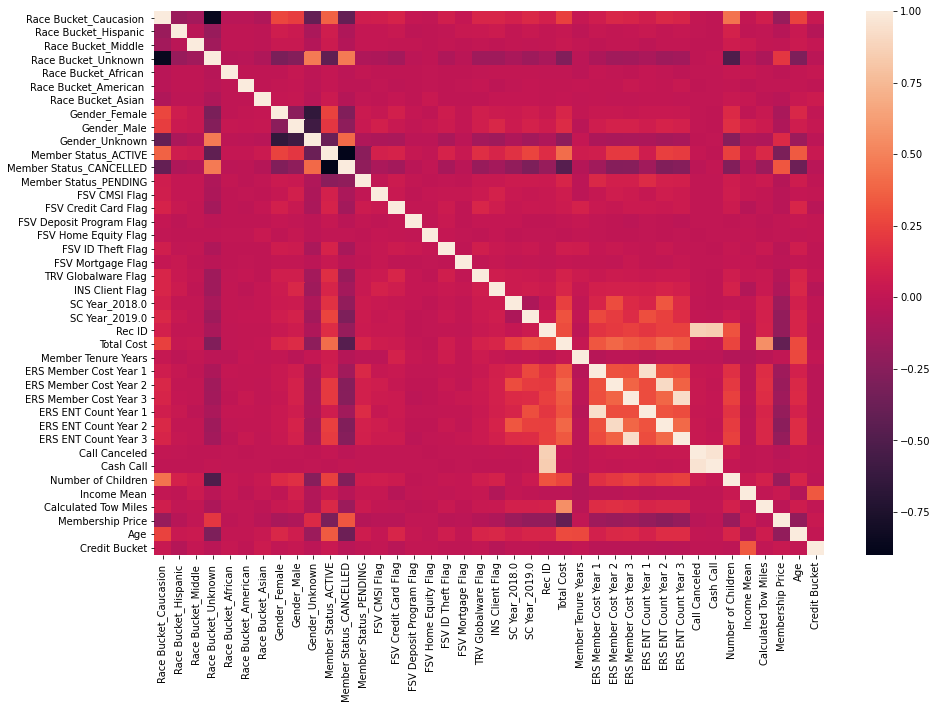

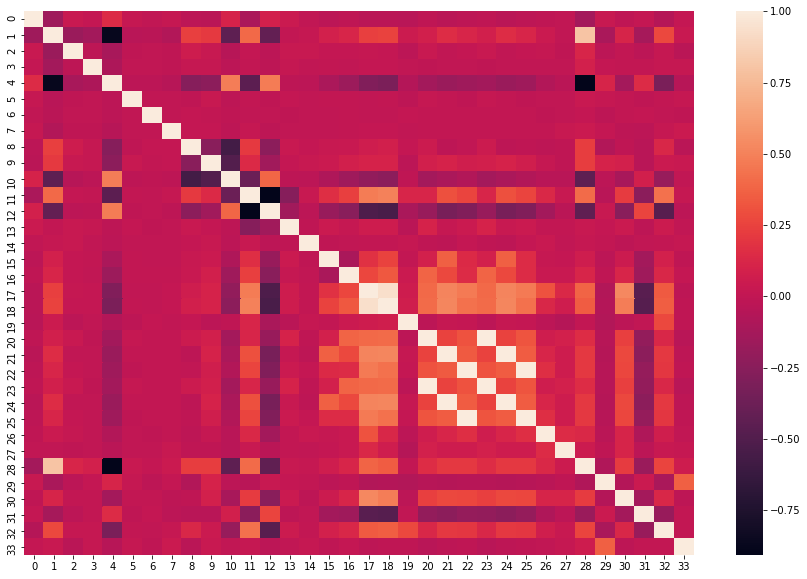

In [0]:
corrMatrixoversampled = pd.DataFrame(X_res).corr()
corrMatrix=member_ads.corr()
plt.figure(figsize=(15,10))
sns.heatmap(corrMatrix)
plt.figure(figsize=(15,10))
sns.heatmap(corrMatrixoversampled)

In [0]:
print(X_res.shape)
print(X_test.shape)

(17202, 34)
(2766, 33)


In [0]:
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE



def adaboost(X_train, X_test, y_train):
    model = AdaBoostClassifier(n_estimators=100, random_state=42)
    model.fit(X_train,y_train)
    y_pred = model.predict(X_test) 
    Y_probs=model.predict_proba(X_test)
    return y_pred, Y_probs

#smotenc+adaboost
y_smote, ysmote_probs = adaboost(X_res, X_test.reset_index(), y_res)

# RUS + adaboost 
X_full = X_train.copy()
X_full['target'] = y_train
X_maj = X_full[X_full.target==0]
X_min = X_full[X_full.target==1]
X_maj_rus = resample(X_maj,replace=False,n_samples=len(X_min),random_state=44)
X_rus = pd.concat([X_maj_rus, X_min])
X_train_rus = X_rus.drop(['target'], axis=1)
y_train_rus = X_rus.target
y_rus, y_rusprobs = adaboost(X_train_rus, X_test, y_train_rus)
 

#Smotenc+logreg and svm
lr=LogisticRegression(penalty='l2', C=4, dual=False, max_iter=10000)
clf = LinearSVC(penalty='l2', max_iter=500, dual=False, C=10,verbose=1)
clf.fit(X_train, y_train)
lr.fit(X_train,y_train)

print("SVM",clf.score(X_test,y_test))
print("Log Reg",lr.score(X_test,y_test))

y_pred = lr.predict(X_test)
y_predsvm=clf.predict(X_test)

from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as plt

conf_matlr = confusion_matrix(y_true=y_test, y_pred=y_pred)
conf_matsvm= confusion_matrix(y_true=y_test, y_pred=y_predsvm)
conf_mat_adasmote= confusion_matrix(y_true=y_test, y_pred=y_smote)
conf_mat_rusada= confusion_matrix(y_true=y_test, y_pred=y_rus)
print('Confusion matrix:\n', conf_matlr)
print('Confusion matrix:\n', conf_matsvm)
print('Confusion matrix:\n', conf_mat_adasmote)
print('Confusion matrix:\n', conf_mat_rusada)

target_names = ['Not Bought', 'Bought']

print('log Report:\n',classification_report(y_test, y_pred, target_names=target_names))

print('svm Report:\n',classification_report(y_test, y_predsvm, target_names=target_names))

print('smote ada Report:\n',classification_report(y_test, y_smote, target_names=target_names))
print('rus ada Report:\n',classification_report(y_test, y_rus, target_names=target_names))


'''
[LibLinear]SVM 0.9070860448300795
Log Reg 0.9070860448300795
Confusion matrix:
 [[2509    0]
 [ 257    0]]
 '''
y_pred


[LibLinear]SVM 0.9070860448300795
Log Reg 0.9070860448300795
Confusion matrix:
 [[2509    0]
 [ 257    0]]
Confusion matrix:
 [[2509    0]
 [ 257    0]]
Confusion matrix:
 [[2254  255]
 [ 200   57]]
Confusion matrix:
 [[1544  965]
 [  78  179]]
log Report:
               precision    recall  f1-score   support

  Not Bought       0.91      1.00      0.95      2509
      Bought       0.00      0.00      0.00       257

    accuracy                           0.91      2766
   macro avg       0.45      0.50      0.48      2766
weighted avg       0.82      0.91      0.86      2766

svm Report:
               precision    recall  f1-score   support

  Not Bought       0.91      1.00      0.95      2509
      Bought       0.00      0.00      0.00       257

    accuracy                           0.91      2766
   macro avg       0.45      0.50      0.48      2766
weighted avg       0.82      0.91      0.86      2766

smote ada Report:
               precision    recall  f1-score   support

 

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



array([0, 0, 0, ..., 0, 0, 0])

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.



[[1975   55]
 [ 176    7]]
CV Report:
               precision    recall  f1-score   support

  Not Bought       0.92      0.97      0.94      2030
      Bought       0.11      0.04      0.06       183

    accuracy                           0.90      2213
   macro avg       0.52      0.51      0.50      2213
weighted avg       0.85      0.90      0.87      2213



/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.



[[1978   47]
 [ 172   16]]
CV Report:
               precision    recall  f1-score   support

  Not Bought       0.92      0.98      0.95      2025
      Bought       0.25      0.09      0.13       188

    accuracy                           0.90      2213
   macro avg       0.59      0.53      0.54      2213
weighted avg       0.86      0.90      0.88      2213



/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.



[[1981   53]
 [ 172    7]]
CV Report:
               precision    recall  f1-score   support

  Not Bought       0.92      0.97      0.95      2034
      Bought       0.12      0.04      0.06       179

    accuracy                           0.90      2213
   macro avg       0.52      0.51      0.50      2213
weighted avg       0.86      0.90      0.87      2213



/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.



[[1970   41]
 [ 187   14]]
CV Report:
               precision    recall  f1-score   support

  Not Bought       0.91      0.98      0.95      2011
      Bought       0.25      0.07      0.11       201

    accuracy                           0.90      2212
   macro avg       0.58      0.52      0.53      2212
weighted avg       0.85      0.90      0.87      2212



/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.



[[1966   53]
 [ 180   13]]
CV Report:
               precision    recall  f1-score   support

  Not Bought       0.92      0.97      0.94      2019
      Bought       0.20      0.07      0.10       193

    accuracy                           0.89      2212
   macro avg       0.56      0.52      0.52      2212
weighted avg       0.85      0.89      0.87      2212



array([0.03825137, 0.08510638, 0.03910615, 0.06965174, 0.06735751])

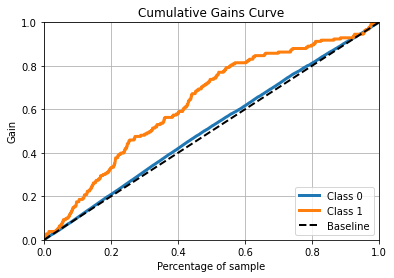

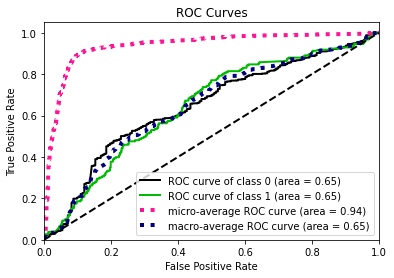

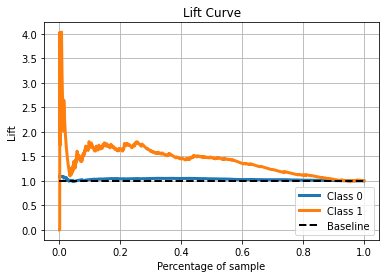

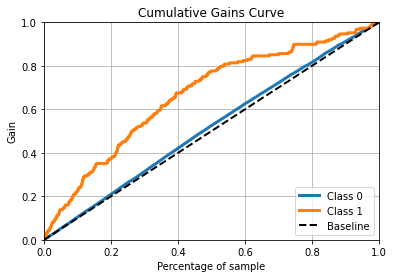

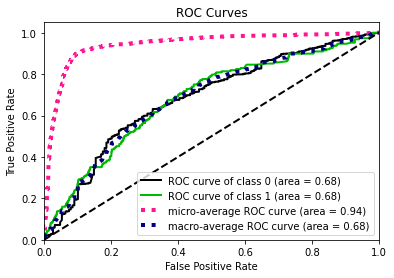

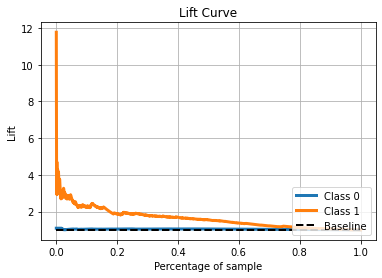

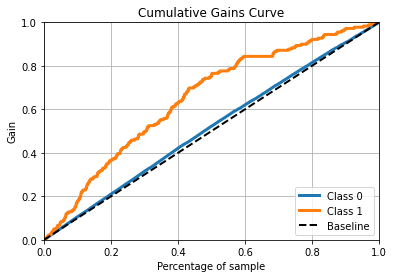

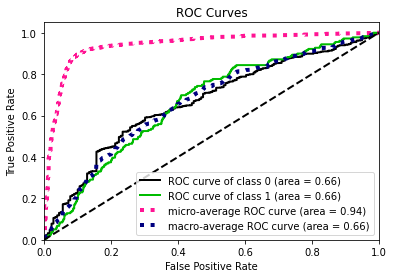

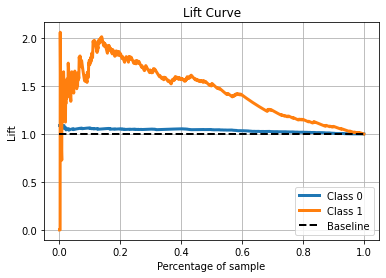

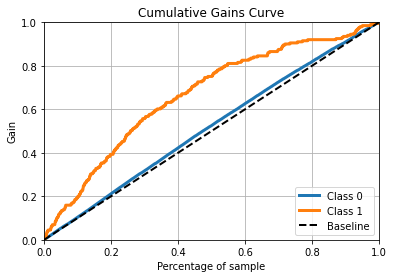

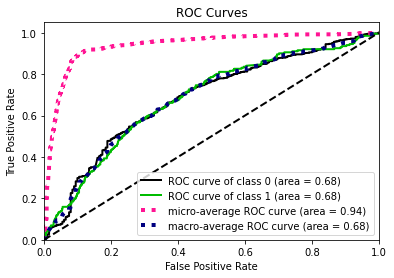

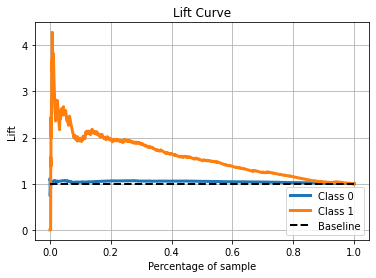

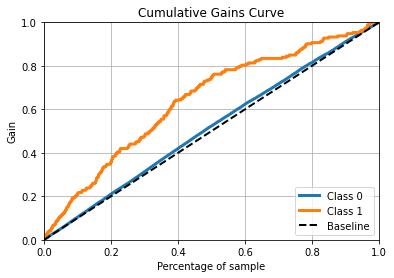

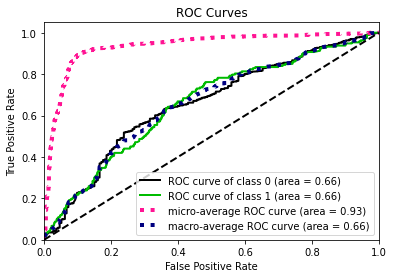

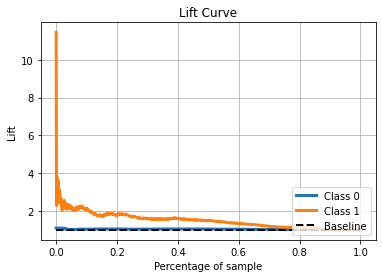

In [0]:

!pip install scikit-plot
import scikitplot as skplot
from sklearn.model_selection import KFold
from sklearn.metrics import recall_score
kf = KFold(n_splits=5, random_state=42, shuffle=True)
example_params = {
        'n_estimators': 500,
        'random_state': 13
    }

from sklearn.utils import resample

#col_list=list(X_new.columns).append('TRV Globalware Flag')
#splitting into training and test
#y_train.value_counts(normalize=True) #91% of members havent bought the product but 8% have


def score_model(model, params, cv=None):
    """
    Creates folds manually, and upsamples within each fold.
    Returns an array of validation (recall) scores
    """
    if cv is None:
        cv = KFold(n_splits=5)

    smoter = SMOTENC(categorical_features=cat_list,sampling_strategy=0.7, k_neighbors=k, random_state=seed)
    
    scores = []

    for train_fold_index, val_fold_index in cv.split(X_train, y_train):
        # Get the training data
        X_train_fold, y_train_fold = X_train.iloc[train_fold_index], y_train.iloc[train_fold_index]
        # Get the validation data
        X_val_fold, y_val_fold = X_train.iloc[val_fold_index], y_train.iloc[val_fold_index]

        # Upsample only the data in the training section
        X_train_fold_upsample, y_train_fold_upsample = smoter.fit_resample(X_train_fold,
                                                                           y_train_fold)
        # Fit the model on the upsampled training data
        model_obj = model(**params).fit(X_train_fold_upsample, y_train_fold_upsample)
        # Score the model on the (non-upsampled) validation data
        score = recall_score(y_val_fold, model_obj.predict(X_val_fold))
        scores.append(score)
        skplot.metrics.plot_cumulative_gain(y_val_fold, model_obj.predict_proba(X_val_fold))
        skplot.metrics.plot_roc_curve(y_val_fold, model_obj.predict_proba(X_val_fold))
        
        skplot.metrics.plot_lift_curve(y_val_fold, model_obj.predict_proba(X_val_fold))
        print(confusion_matrix(y_true=y_val_fold, y_pred= model_obj.predict(X_val_fold)))
        print('CV Report:\n',classification_report(y_val_fold,model_obj.predict(X_val_fold), target_names=target_names))
    return np.array(scores)

# Example of the model in action
score_model(AdaBoostClassifier, example_params, cv=kf)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.



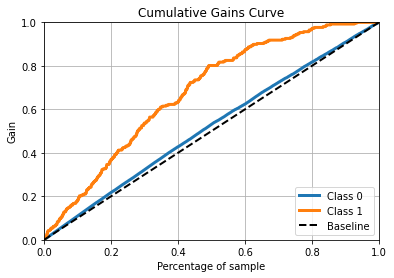

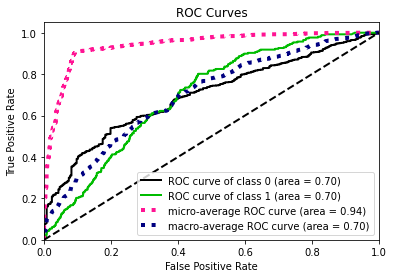

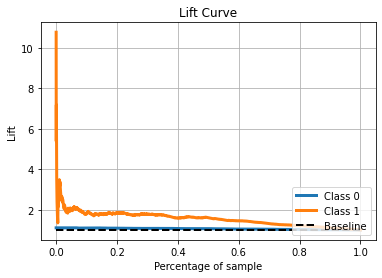

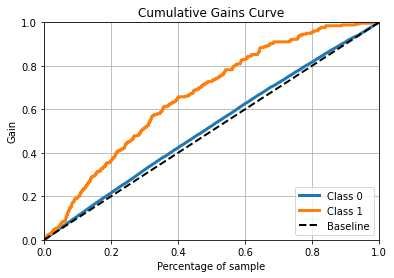

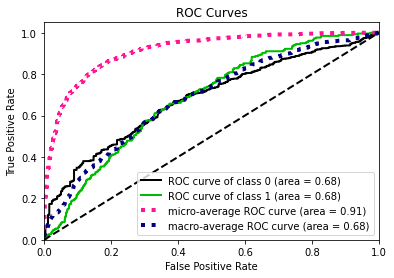

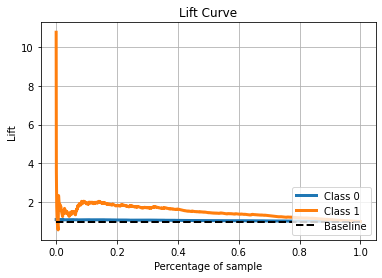

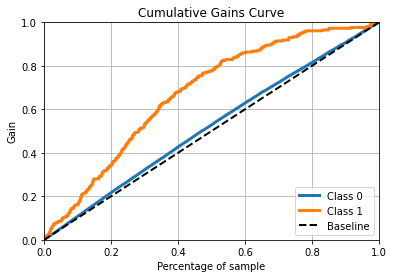

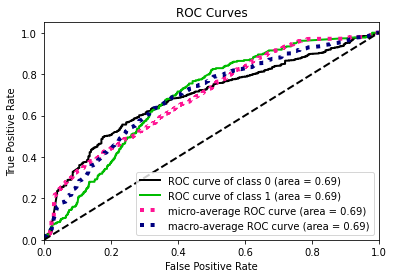

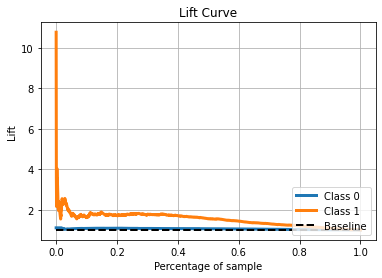

In [0]:


skplot.metrics.plot_cumulative_gain(y_test, lr.predict_proba(X_test))
skplot.metrics.plot_roc_curve(y_test, lr.predict_proba(X_test))
skplot.metrics.plot_lift_curve(y_test, lr.predict_proba(X_test))

skplot.metrics.plot_cumulative_gain(y_test, ysmote_probs)
skplot.metrics.plot_roc_curve(y_test, ysmote_probs)
skplot.metrics.plot_lift_curve(y_test, ysmote_probs)

skplot.metrics.plot_cumulative_gain(y_test, y_rusprobs)
skplot.metrics.plot_roc_curve(y_test, y_rusprobs)
skplot.metrics.plot_lift_curve(y_test, y_rusprobs)

In [0]:
X_train.columns

Index(['Race Bucket_Caucasion ', 'Race Bucket_Hispanic ',
       'Race Bucket_Middle ', 'Race Bucket_Unknown ', 'Race Bucket_African ',
       'Race Bucket_American ', 'Race Bucket_Asian ', 'Gender_Female',
       'Gender_Male', 'Gender_Unknown', 'Member Status_ACTIVE',
       'Member Status_CANCELLED', 'Member Status_PENDING', 'FSV Mortgage Flag',
       'SC Year_2018.0', 'SC Year_2019.0', 'Rec ID', 'Total Cost',
       'Member Tenure Years', 'ERS Member Cost Year 1',
       'ERS Member Cost Year 2', 'ERS Member Cost Year 3',
       'ERS ENT Count Year 1', 'ERS ENT Count Year 2', 'ERS ENT Count Year 3',
       'Call Canceled', 'Cash Call', 'Number of Children', 'Income Mean',
       'Calculated Tow Miles', 'Membership Price', 'Age', 'Credit Bucket'],
      dtype='object')

[6.94235103 2.77883839 1.6997662 ]
[0.21147515 0.08464787 0.05177761]
[ 0.00041614  0.00427353  0.00215846 -0.00092387  0.00355002 -0.00649911
 -0.00613704  0.0044007  -0.01138916  0.00518876 -0.00254935 -0.00071008
  0.00718118 -0.00212656 -0.00581357  0.00259554  0.00114894  0.00067774
 -0.00313283 -0.00250383 -0.0044294  -0.00083522 -0.00239399 -0.00456246
 -0.00091135  0.00259384  0.00066507  0.00026765 -0.0050207  -0.00372368
  0.00116361 -0.00349753 -0.00144097]


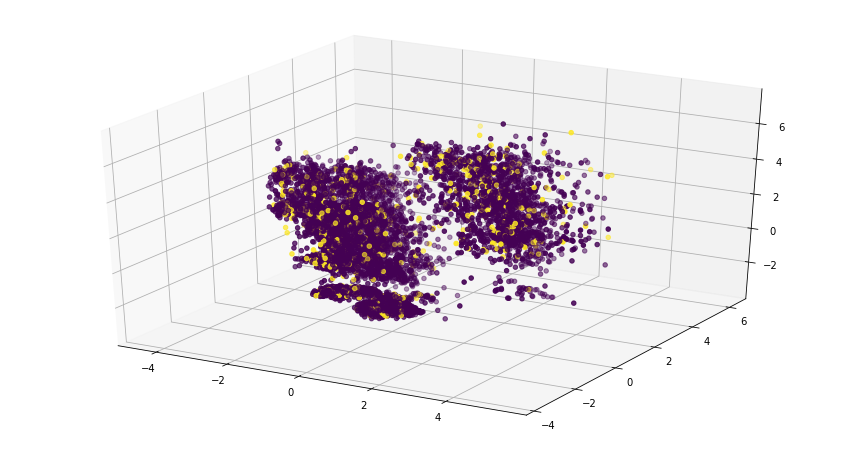

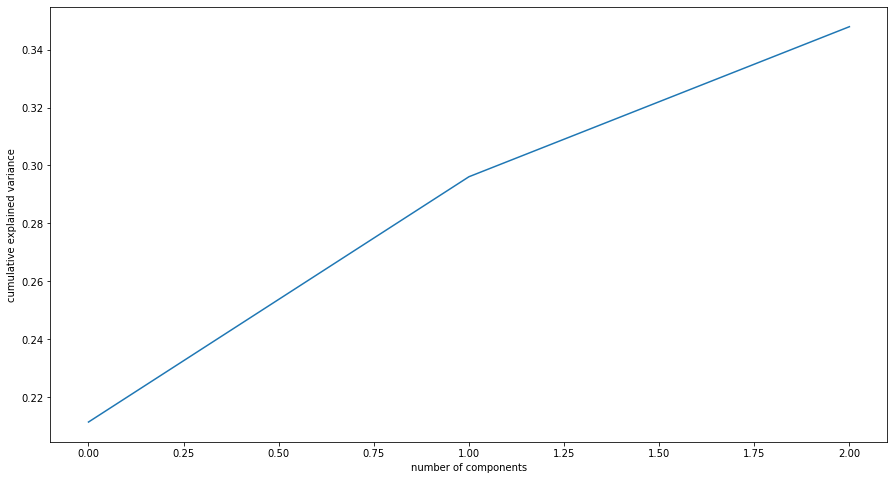

In [0]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler




pca = PCA(n_components=3)
pca_df = pca.fit_transform(X_train)


def plot_2d_space(X, y, label='Classes'):   
    colors = ['#1F77B4', '#FF7F0E']
    markers = ['o', 's']
    for l, c, m in zip(np.unique(y), colors, markers):
        plt.scatter(
            X[y==l, 0],
            X[y==l, 1],
            c=c, label=l, marker=m
        )
    plt.title(label)
    plt.legend(loc='upper right')
    plt.show()

fig=plt.figure(figsize=(15,8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(pca_df[:,2], pca_df[:,1],pca_df[:,0] ,c=y_train)
#plot_2d_space(pca_df, y_train, 'Imbalanced dataset (2 PCA components)')
#plot_2d_space()

ax.scatter(pca_df[:,2], pca_df[:,1],pca_df[:,0] ,c=y_train)

#print(pca.components_)
print(pca.explained_variance_)
print(pca.explained_variance_ratio_)
print(pca.mean_)

#print(pca.score)

pca_df


fig=plt.figure(figsize=(15,8))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');


In [0]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

lda = LDA(n_components=1)
X_trainlda = lda.fit_transform(X_train, y_train)
X_testlda = lda.transform(X_test)
lda.explained_variance_ratio_

array([1.])

In [0]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

#HouseHold Level Analysis

In [0]:
#building an analytical dataset for the household- 
#we characterize that to make our purchasing decision since the desparity of classes will be lower
Household_ads=member_df_dummies.groupby(['Household Key']).agg({'Individual Key':'count','Rec ID':"count",'Total Cost': "mean",
                                                  'Member Tenure Years': "mean",
                                               # 'ERS Member Cost Year 1': "mean", 
                                                # 'ERS Member Cost Year 2':"mean",
                                                #'ERS Member Cost Year 3':"mean",
                                                # 'ERS ENT Count Year 1': "mean", 
                                                #'ERS ENT Count Year 2': "mean",
                                                # 'ERS ENT Count Year 3': "mean",
                                                 'Call Canceled': "sum", 
                                                 'Cash Call': "sum",
                                                 'Number of Children': "sum",
                                                 'Income Mean': "mean",
                                                 'Calculated Tow Miles': "sum",
                                                 'Membership Price': "mean",
                                                 'Age': "max",
                                                 'Credit Bucket':'max',
                                                 'Race Bucket_Caucasion ':'sum',
                                                 'Race Bucket_Hispanic ': 'sum'
                                                 ,'Race Bucket_Middle ': 'sum', 
                                                 'Race Bucket_Unknown ': 'sum',
                                                  'Race Bucket_African ': 'sum',
                                                   'Race Bucket_American ': 'sum',
                                                   'Race Bucket_Asian ': 'sum',
                                                    'Gender_Female': 'sum',
                                                    'Gender_Male': 'sum',
                                                     'Gender_Unknown': 'sum',
                                                      'Member Status_ACTIVE': 'sum',
                                                       'Member Status_CANCELLED': 'sum', 
                                                       'Member Status_PENDING': 'sum',
                                                       'FSV CMSI Flag': 'sum',
                                                       'FSV Credit Card Flag': 'sum',
                                                       'FSV Deposit Program Flag': 'sum',
                                                         'FSV Home Equity Flag': 'sum',
                                                         'FSV ID Theft Flag': 'sum',
                                                          'FSV Mortgage Flag': 'sum',
                                                          'TRV Globalware Flag': 'sum',
                                                          'INS Client Flag': 'sum',
                                                  }).reset_index()
                                                                                                

#member_ads.drop('FSV Mortgage Flag', inplace=True)
def flag_prod(x):
  if x>0:return 1
  else: return 0

Household_ads.fillna(0,inplace=True)


In [0]:
fsvs= [i for i in Household_ads.columns if i.startswith('FSV')]
for col in fsvs:
    Household_ads[col]=Household_ads[col].apply(flag_prod)
#other product mapping
Household_ads['INS Client Flag']=Household_ads['INS Client Flag'].apply(flag_prod)
Household_ads['TRV Globalware Flag']=Household_ads['TRV Globalware Flag'].apply(flag_prod)
Household_ads

,Household Key,Individual Key,Rec ID,Total Cost,Member Tenure Years,Call Canceled,Cash Call,Number of Children,Income Mean,Calculated Tow Miles,Membership Price,Age,Credit Bucket,Race Bucket_Caucasion,Race Bucket_Hispanic,Race Bucket_Middle,Race Bucket_Unknown,Race Bucket_African,Race Bucket_American,Race Bucket_Asian,Gender_Female,Gender_Male,Gender_Unknown,Member Status_ACTIVE,Member Status_CANCELLED,Member Status_PENDING,FSV CMSI Flag,FSV Credit Card Flag,FSV Deposit Program Flag,FSV Home Equity Flag,FSV ID Theft Flag,FSV Mortgage Flag,TRV Globalware Flag,INS Client Flag
0,875.0,18,14,75.942857,28.944444,0,0,0.0,58311.510927,112.2,87.055556,97.0,2.537858,0,0,0,18.0,0,0,0,0,0,18.0,9,4.0,5,0,1,0,0,0,0,0,0
1,969.0,6,4,56.525000,35.333333,1,0,2.0,55555.840618,9.0,89.000000,76.0,4.000000,1,0,0,4.0,0,0,0,1,2,3.0,6,0.0,0,0,0,0,0,0,0,0,1
2,3338.0,3,0,0.000000,37.333333,0,0,2.0,42209.173951,0.0,89.000000,89.0,2.537858,1,0,0,2.0,0,0,0,0,0,3.0,0,3.0,0,0,0,0,0,0,0,0,0
3,8718.0,2,0,0.000000,10.000000,0,0,1.0,44168.005463,0.0,89.000000,68.0,4.000000,1,0,0,1.0,0,0,0,0,1,1.0,1,1.0,0,0,0,0,0,0,0,1,0
4,11524.0,7,5,58.850000,36.285714,0,0,15.0,92933.071429,6.0,64.000000,75.0,3.000000,7,0,0,0.0,0,0,0,1,4,2.0,4,1.0,2,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5236,100069201.0,2,2,53.000000,65.000000,0,0,2.0,58311.510927,12.0,54.000000,86.0,2.537858,0,0,0,0.0,0,0,0,2,0,0.0,2,0.0,0,0,0,0,0,0,0,0,1
5237,100070004.0,4,2,30.000000,45.750000,0,0,0.0,58311.510927,4.1,104.000000,88.0,2.537858,0,0,0,4.0,0,0,0,0,0,4.0,0,4.0,0,0,0,0,0,0,0,0,0
5238,100071861.0,10,8,55.925000,43.500000,0,0,8.0,27673.902185,4.0,61.000000,95.0,2.537858,8,0,0,2.0,0,0,0,0,0,10.0,8,2.0,0,0,0,0,0,0,0,0,0
5239,100071870.0,7,6,35.166667,13.000000,0,0,0.0,58311.510927,9.0,59.000000,100.0,2.537858,0,0,0,7.0,0,0,0,0,0,7.0,0,7.0,0,0,0,0,0,0,0,0,1


In [0]:
print(Household_ads['TRV Globalware Flag'].value_counts())
print(Household_ads['INS Client Flag'].value_counts())
print(Household_ads['FSV Credit Card Flag'].value_counts())
print(Household_ads['FSV Deposit Program Flag'].value_counts())
print(Household_ads['FSV Home Equity Flag'].value_counts())
print(Household_ads['FSV ID Theft Flag'].value_counts())
print(Household_ads['FSV CMSI Flag'].value_counts())


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PowerTransformer
pt = PowerTransformer()

X_new = Household_ads.drop(product_cols, axis=1)
X_new_temp=X_new.set_index('Household Key')
y_new = Household_ads['TRV Globalware Flag']
transformed_df=pt.fit_transform(X_new.set_index('Household Key'))
transformed_df=pd.DataFrame(transformed_df, index=X_new_temp.index, columns=X_new.set_index('Household Key').columns)
#transformed_df.columns=X_new.columns

col_list=list(X_new.columns).append('TRV Globalware Flag')
#splitting into training and test
X_train, X_test, y_train, y_test = train_test_split(transformed_df.reset_index(), y_new, test_size=0.2, random_state=0)
y_train.value_counts(normalize=True) #91% of members havent bought the product but 8% have
transformed_df
X_train

0    4510
1     731
Name: TRV Globalware Flag, dtype: int64
0    3800
1    1441
Name: INS Client Flag, dtype: int64
0    4663
1     578
Name: FSV Credit Card Flag, dtype: int64
0    5213
1      28
Name: FSV Deposit Program Flag, dtype: int64
0    5235
1       6
Name: FSV Home Equity Flag, dtype: int64
0    5006
1     235
Name: FSV ID Theft Flag, dtype: int64
0    4873
1     368
Name: FSV CMSI Flag, dtype: int64


,Household Key,Individual Key,Rec ID,Total Cost,Member Tenure Years,Call Canceled,Cash Call,Number of Children,Income Mean,Calculated Tow Miles,Membership Price,Age,Credit Bucket,Race Bucket_Caucasion,Race Bucket_Hispanic,Race Bucket_Middle,Race Bucket_Unknown,Race Bucket_African,Race Bucket_American,Race Bucket_Asian,Gender_Female,Gender_Male,Gender_Unknown,Member Status_ACTIVE,Member Status_CANCELLED,Member Status_PENDING,FSV Mortgage Flag
3944,16616199.0,-1.450415,-1.181811,-1.291825,0.620867,-0.402277,-0.130681,-0.314398,0.806857,-0.679271,0.641213,-0.106083,-2.672082,0.083218,-0.219067,-0.172825,-1.299902,-0.06032,-0.051753,-0.102983,0.970957,-0.652816,-1.556380,-0.028711,-1.339634,-0.294012,-0.045861
1414,5144534.0,-0.494113,-0.154194,0.868485,0.582826,-0.402277,-0.130681,0.640923,-0.110935,-0.679271,0.641213,0.433650,-1.146150,0.613767,-0.219067,-0.172825,-1.299902,-0.06032,-0.051753,-0.102983,0.970957,1.298394,-1.556380,-0.028711,0.016055,-0.294012,-0.045861
1951,7295976.0,-0.494113,-1.181811,-1.291825,-1.845629,-0.402277,-0.130681,0.141705,-2.215077,-0.679271,0.641213,-0.170435,-1.146150,-1.105988,-0.219067,5.786213,-1.299902,-0.06032,-0.051753,-0.102983,0.970957,1.298394,-1.556380,-1.128362,0.016055,3.398949,-0.045861
3456,13728273.0,-1.450415,-1.181811,-1.291825,0.469071,-0.402277,-0.130681,-1.238934,0.221013,-0.679271,0.641213,1.563234,-0.281583,-1.105988,-0.219067,-0.172825,0.006286,-0.06032,-0.051753,-0.102983,-0.780776,-0.652816,-0.345496,-1.128362,0.016055,-0.294012,-0.045861
45,195448.0,0.075152,0.350441,0.868485,-0.004839,-0.402277,-0.130681,-1.238934,0.221013,-0.679271,0.641213,-0.106083,-0.281583,-1.105988,-0.219067,-0.172825,1.004101,-0.06032,-0.051753,-0.102983,-0.780776,-0.652816,0.684396,0.487968,0.016055,-0.294012,-0.045861
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4931,40682673.0,-0.494113,0.350441,0.565305,0.850354,-0.402277,-0.130681,0.141705,-2.755534,1.531958,0.641213,0.575454,-1.146150,0.613767,-0.219067,-0.172825,-1.299902,-0.06032,-0.051753,-0.102983,-0.780776,1.611069,-1.556380,0.487968,-1.339634,-0.294012,-0.045861
3264,13029984.0,1.532353,1.593411,0.847759,-0.346818,2.490646,-0.130681,-1.238934,0.221013,1.735424,-1.665352,0.575454,-0.281583,-1.105988,-0.219067,-0.172825,2.053379,-0.06032,-0.051753,-0.102983,-0.780776,-0.652816,1.917640,1.333967,-1.339634,3.402636,-0.045861
1653,6117070.0,1.626365,1.217538,0.886138,-1.259888,-0.402277,-0.130681,0.929371,0.552744,1.616179,-0.837821,-0.420862,-0.281583,1.435184,-0.219067,-0.172825,1.474676,-0.06032,-0.051753,-0.102983,1.737876,-0.652816,1.213923,1.333967,1.659804,-0.294012,-0.045861
2607,10052163.0,-0.494113,-1.181811,-1.291825,-0.054087,-0.402277,-0.130681,-1.238934,0.221013,-0.679271,0.641213,-0.718071,-0.281583,-1.105988,-0.219067,-0.172825,0.622294,-0.06032,-0.051753,-0.102983,-0.780776,-0.652816,0.277089,-0.028711,0.016055,-0.294012,-0.045861


In [0]:
from sklearn.model_selection import KFold
from sklearn.metrics import recall_score
kf = KFold(n_splits=5, random_state=42, shuffle=True)
example_params = {
        'n_estimators': 500,
        'random_state': 13
    }

#col_list=list(X_new.columns).append('TRV Globalware Flag')
#splitting into training and test
#y_train.value_counts(normalize=True) #91% of members havent bought the product but 8% have


def score_model(model, params, cv=None):
    """
    Creates folds manually, and upsamples within each fold.
    Returns an array of validation (recall) scores
    """
    if cv is None:
        cv = KFold(n_splits=5)

    smoter = SMOTE(sampling_strategy=0.7, k_neighbors=k, random_state=seed)
    
    scores = []

    for train_fold_index, val_fold_index in cv.split(X_train, y_train):
        # Get the training data
        X_train_fold, y_train_fold = X_train.iloc[train_fold_index], y_train.iloc[train_fold_index]
        # Get the validation data
        X_val_fold, y_val_fold = X_train.iloc[val_fold_index], y_train.iloc[val_fold_index]

        # Upsample only the data in the training section
        X_train_fold_upsample, y_train_fold_upsample = smoter.fit_resample(X_train_fold,
                                                                           y_train_fold)
        # Fit the model on the upsampled training data
        model_obj = model(**params).fit(X_train_fold_upsample, y_train_fold_upsample)
        # Score the model on the (non-upsampled) validation data
        score = recall_score(y_val_fold, model_obj.predict(X_val_fold))
        scores.append(score)
        skplot.metrics.plot_cumulative_gain(y_val_fold, model_obj.predict_proba(X_val_fold))
        skplot.metrics.plot_roc_curve(y_val_fold, model_obj.predict_proba(X_val_fold))
        
        skplot.metrics.plot_lift_curve(y_val_fold, model_obj.predict_proba(X_val_fold))
        print(confusion_matrix(y_true=y_val_fold, y_pred= model_obj.predict(X_val_fold)))
        print('CV Report:\n',classification_report(y_val_fold,model_obj.predict(X_val_fold), target_names=target_names))
    return np.array(scores)

# Example of the model in action
score_model(AdaBoostClassifier, example_params, cv=kf)

Classifier for TRV Globalware Flag

In [0]:
!pip install xgboost
from numpy import loadtxt
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

params={'n_estimators': [50, 100],
 'max_depth': [4, 6],
 'scale_pos_weight': [2,  8, 10,100],
 'alpha':[5],
 'learning_rate':[0.1],
 'random_state': [13]}
model = XGBClassifier(objective='binary:logistic', booster='gbtree', colsample_bytree= 0.3)
# define evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# define grid search
grid = GridSearchCV(estimator=model, param_grid=params, n_jobs=-1, cv=cv, scoring='recall')  
grid_result = grid.fit(X_train.set_index('Household Key'), y_train)        

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
# report all configurations
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

[[111 810]
 [  4 124]]
              precision    recall  f1-score   support

  Not Bought       0.97      0.12      0.21       921
      Bought       0.13      0.97      0.23       128

    accuracy                           0.22      1049
   macro avg       0.55      0.54      0.22      1049
weighted avg       0.86      0.22      0.22      1049



/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.



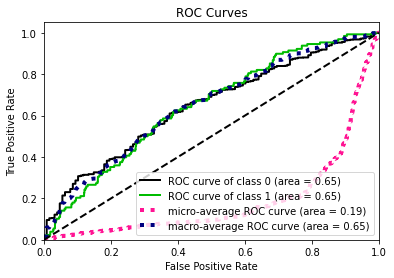

In [0]:
#Best: 0.760046 using {'alpha': 5, 'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 50, 'random_state': 13, 'scale_pos_weight': 8}

#Best: 0.963506 using {'alpha': 5, 'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 50, 'random_state': 13, 'scale_pos_weight': 100}
from sklearn.metrics import confusion_matrix

!pip install scikit-plot
import scikitplot as skplot
from sklearn.metrics import classification_report
X_train.set_index('Household Key').columns
y_test_predict = grid_result.predict(X_test.set_index('Household Key'))
print(confusion_matrix(y_true=y_test, y_pred=y_test_predict, labels=[0,1]))

feat_imp=grid.best_estimator_.feature_importances_
# plot

y_test_predict_proba = grid_result.predict_proba(X_test.set_index('Household Key'))
target_names = ['Not Bought', 'Bought']
skplot.metrics.plot_roc_curve(y_test, y_test_predict_proba)
print(classification_report(y_test,y_test_predict, target_names=target_names))


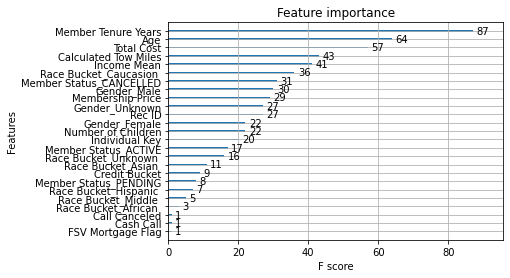

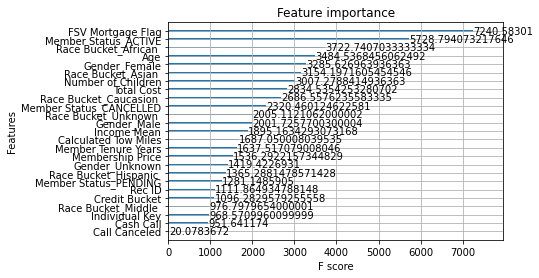

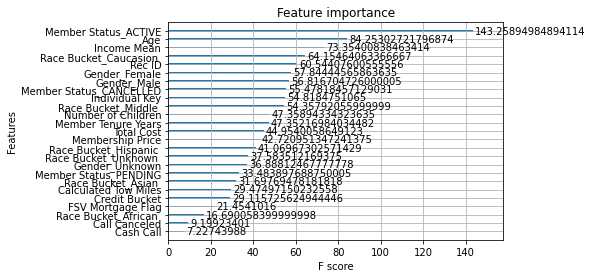

In [0]:
from xgboost import plot_importance
from matplotlib import pyplot
y_test_predict = grid_result.predict(X_test.set_index('Household Key'))
confusion_matrix(y_true=y_test, y_pred=y_test_predict)

feat_imp=grid.best_estimator_.feature_importances_
# plot
#plt.bar(range(len(grid.best_estimator_.feature_importances_)), grid.best_estimator_.feature_importances_)
#plt.show()
feat_imp=pd.DataFrame(feat_imp)
feat_imp['Columns']=X_train.set_index('Household Key').columns
feat_imp.set_index('Columns', inplace=True)

plot_importance(grid.best_estimator_)
pyplot.show()
plot_importance(grid.best_estimator_, importance_type= 'cover')
pyplot.show()
plot_importance(grid.best_estimator_, importance_type= 'gain')
pyplot.show()



In [0]:
print(product_cols)
print(Household_ads['FSV CMSI Flag'].value_counts(normalize=True))
y_new = Household_ads['FSV CMSI Flag']
col_list=list(X_new.columns).append('FSV CMSI Flag')
#transformed_df
X_train, X_test, y_train, y_test = train_test_split(transformed_df.reset_index(), y_new, test_size=0.2, random_state=0)


['FSV Credit Card Flag', 'FSV CMSI Flag', 'FSV Deposit Program Flag', 'FSV Home Equity Flag', 'FSV ID Theft Flag', 'TRV Globalware Flag', 'INS Client Flag']
0    0.929784
1    0.070216
Name: FSV CMSI Flag, dtype: float64


In [0]:

params={'n_estimators': [50, 100],
 'max_depth': [4, 6],
 'scale_pos_weight': [ 8, 50],
 'alpha':[5],
 'learning_rate':[0.1],
 'random_state': [13]}
modelcmsi = XGBClassifier(objective='binary:logistic', booster='gbtree', colsample_bytree= 0.3)
# define evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# define grid search
grid = GridSearchCV(estimator=modelcmsi, param_grid=params, n_jobs=-1, cv=cv, scoring='recall')  
grid_result = grid.fit(X_train.set_index('Household Key'), y_train)        

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
# report all configurations
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))



Best: 0.853908 using {'alpha': 5, 'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 50, 'random_state': 13, 'scale_pos_weight': 50}
0.331801 (0.087159) with: {'alpha': 5, 'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 50, 'random_state': 13, 'scale_pos_weight': 8}
0.853908 (0.054593) with: {'alpha': 5, 'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 50, 'random_state': 13, 'scale_pos_weight': 50}
0.283946 (0.076652) with: {'alpha': 5, 'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 100, 'random_state': 13, 'scale_pos_weight': 8}
0.745441 (0.089025) with: {'alpha': 5, 'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 100, 'random_state': 13, 'scale_pos_weight': 50}
0.178008 (0.047766) with: {'alpha': 5, 'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 50, 'random_state': 13, 'scale_pos_weight': 8}
0.668889 (0.079511) with: {'alpha': 5, 'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 50, 'random_state': 13, 'scale_pos_weight': 50}
0.138123 (0.039074)

[[413 560]
 [  6  70]]
              precision    recall  f1-score   support

  Not Bought       0.99      0.42      0.59       973
      Bought       0.11      0.92      0.20        76

    accuracy                           0.46      1049
   macro avg       0.55      0.67      0.40      1049
weighted avg       0.92      0.46      0.56      1049



/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.



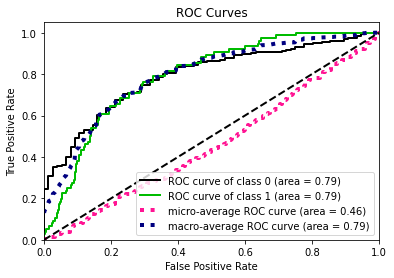

In [0]:
from sklearn.metrics import confusion_matrix
#Best: 0.853908 using {'alpha': 5, 'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 50, 'random_state': 13, 'scale_pos_weight': 50}
!pip install scikit-plot
import scikitplot as skplot
from sklearn.metrics import classification_report
X_train.set_index('Household Key').columns
y_test_predict = grid_result.predict(X_test.set_index('Household Key'))
print(confusion_matrix(y_true=y_test, y_pred=y_test_predict, labels=[0,1]))

feat_imp=grid.best_estimator_.feature_importances_
# plot

y_test_predict_proba = grid_result.predict_proba(X_test.set_index('Household Key'))
target_names = ['Not Bought', 'Bought']
skplot.metrics.plot_roc_curve(y_test, y_test_predict_proba)
print(classification_report(y_test,y_test_predict, target_names=target_names))


In [0]:
#need sampling method to tackle this issue


# for reproducibility purposes
seed = 100
# SMOTE number of neighbors
k = 5

cat_list=list(range(14)) #categorical features in the dataset there are 15 
from imblearn.over_sampling import SMOTENC
sm = SMOTENC(categorical_features=cat_list,sampling_strategy=0.7, k_neighbors=k, random_state=seed)

#Upsample to get 70% of minority class
from collections import Counter
X_res, y_res =sm.fit_resample(X_train, y_train)
print(sorted(Counter(y_res).items()))


/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning:

The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning:

The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function safe_indexing is deprecated; safe_indexing i

[(0, 3900), (1, 2730)]


In [0]:
dict_y=list(Counter(y_res).items())
items=round(dict_y[0][1]*0.7)
items

2730

In [0]:
col_list=list(X_new.columns)
col_list.append("FSV CMSI Flag")
#col_list.insert(0,"Household Key")


X_Y_res = pd.concat([pd.DataFrame(X_res), pd.DataFrame(y_res)], axis=1)
X_Y_res.columns=col_list
X_downsampled=X_Y_res[X_Y_res['FSV CMSI Flag']==0].sample(items)

new_Df=pd.concat([X_Y_res[X_Y_res['FSV CMSI Flag']==1], X_downsampled], axis=0)
X_test

,Household Key,Individual Key,Rec ID,Total Cost,Member Tenure Years,Call Canceled,Cash Call,Number of Children,Income Mean,Calculated Tow Miles,Membership Price,Age,Credit Bucket,Race Bucket_Caucasion,Race Bucket_Hispanic,Race Bucket_Middle,Race Bucket_Unknown,Race Bucket_African,Race Bucket_American,Race Bucket_Asian,Gender_Female,Gender_Male,Gender_Unknown,Member Status_ACTIVE,Member Status_CANCELLED,Member Status_PENDING,FSV Mortgage Flag
3199,12479183.0,0.463236,0.900709,0.868485,1.393638,-0.402277,-0.130681,0.640923,-1.106321,1.281612,-1.665352,0.226081,-1.146150,-1.105988,4.564819,-0.172825,-1.299902,-0.06032,-0.051753,-0.102983,-0.780776,1.755057,-1.556380,1.031455,-1.339634,-0.294012,-0.045861
5170,95181849.0,-1.450415,-1.181811,-1.291825,1.315388,-0.402277,-0.130681,-0.314398,-0.110935,-0.679271,0.641213,0.294584,-1.146150,0.083218,-0.219067,-0.172825,-1.299902,-0.06032,-0.051753,-0.102983,-0.780776,1.298394,-1.556380,-1.128362,0.016055,-0.294012,-0.045861
861,3163101.0,-0.494113,-1.181811,-1.291825,0.582826,-0.402277,-0.130681,-1.238934,0.221013,-0.679271,0.641213,0.941876,-0.281583,-1.105988,-0.219067,-0.172825,0.622294,-0.06032,-0.051753,-0.102983,-0.780776,-0.652816,0.277089,-1.128362,0.687014,-0.294012,-0.045861
5017,72206568.0,0.075152,-0.154194,0.288859,-0.249781,-0.402277,-0.130681,-0.314398,-0.233005,-0.679271,0.641213,0.433650,-0.281583,0.083218,-0.219067,-0.172825,0.622294,-0.06032,-0.051753,-0.102983,-0.780776,1.298394,0.277089,-1.128362,1.115610,-0.294012,-0.045861
2838,11065297.0,1.532353,1.518556,0.719115,-1.387370,2.484608,-0.130681,1.866016,-0.494635,1.706455,-1.511941,-0.420862,-0.281583,-1.105988,4.564819,-0.172825,1.004101,-0.06032,-0.051753,-0.102983,1.562062,1.611069,1.213923,1.613626,0.016055,-0.294012,-0.045861
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2300,8669252.0,-0.494113,-0.154194,0.868485,0.168513,-0.402277,-0.130681,1.387955,-0.110935,-0.679271,2.227183,-0.601308,-1.146150,-1.105988,4.564819,-0.172825,-1.299902,-0.06032,-0.051753,-0.102983,0.970957,1.298394,-1.556380,-0.028711,-1.339634,3.398949,-0.045861
220,723879.0,-0.494113,-1.181811,-1.291825,1.393638,-0.402277,-0.130681,-1.238934,0.221013,-0.679271,0.641213,1.093183,-0.281583,-1.105988,-0.219067,-0.172825,0.622294,-0.06032,-0.051753,-0.102983,-0.780776,-0.652816,0.277089,-1.128362,0.687014,-0.294012,-0.045861
1940,7262603.0,0.971784,1.076562,0.836076,-0.346818,-0.402277,-0.130681,-1.238934,0.221013,1.529413,-1.400997,-0.170435,-0.281583,-1.105988,-0.219067,-0.172825,1.635010,-0.06032,-0.051753,-0.102983,-0.780776,1.755057,0.277089,1.200356,0.016055,-0.294012,-0.045861
5065,83859770.0,0.749472,-0.154194,0.971420,-1.694303,-0.402277,-0.130681,1.126138,0.527006,-0.679271,0.032404,0.158266,0.481784,1.148896,-0.219067,-0.172825,0.006286,-0.06032,-0.051753,-0.102983,1.390555,1.611069,-0.345496,0.487968,1.115610,-0.294012,-0.045861


In [0]:
cols=X_test.drop(columns=['FSV Mortgage Flag','Household Key']).columns
cols

Index(['Individual Key', 'Rec ID', 'Total Cost', 'Member Tenure Years',
       'Call Canceled', 'Cash Call', 'Number of Children', 'Income Mean',
       'Calculated Tow Miles', 'Membership Price', 'Age', 'Credit Bucket',
       'Race Bucket_Caucasion ', 'Race Bucket_Hispanic ',
       'Race Bucket_Middle ', 'Race Bucket_Unknown ', 'Race Bucket_African ',
       'Race Bucket_American ', 'Race Bucket_Asian ', 'Gender_Female',
       'Gender_Male', 'Gender_Unknown', 'Member Status_ACTIVE',
       'Member Status_CANCELLED', 'Member Status_PENDING'],
      dtype='object')

In [0]:

from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE
from sklearn.utils import resample

def adaboost(X_train, X_test, y_train):
    model = AdaBoostClassifier(n_estimators=100, random_state=42)
    model.fit(X_train,y_train)
    y_pred = model.predict(X_test) 
    Y_probs=model.predict_proba(X_test)
    print(cols,model.feature_importances_)
    return y_pred, Y_probs

#smotenc+adaboost
y_smote, ysmote_probs = adaboost(X_res, X_test, y_res)

# RUS + adaboost 
X_full = X_train.drop(columns=['FSV Mortgage Flag','Household Key']).copy()
X_full['target'] = y_train
X_maj = X_full[X_full.target==0]
X_min = X_full[X_full.target==1]
X_maj_rus = resample(X_maj,replace=False,n_samples=len(X_min),random_state=44)
X_rus = pd.concat([X_maj_rus, X_min])
X_train_rus = X_rus.drop(['target'], axis=1)
y_train_rus = X_rus.target
y_rus, y_rusprobs = adaboost(X_train_rus, X_test.drop(columns=['FSV Mortgage Flag','Household Key']), y_train_rus)
 

#Smotenc+logreg and svm
lr=LogisticRegression(penalty='l2', C=4, dual=False, max_iter=10000)
clf = LinearSVC(penalty='l2', max_iter=500, dual=False, C=10,verbose=1)
clf.fit(new_Df.drop(columns=["FSV CMSI Flag",'FSV Mortgage Flag','Household Key']), new_Df['FSV CMSI Flag'])
lr.fit(new_Df.drop(columns=["FSV CMSI Flag",'FSV Mortgage Flag','Household Key']), new_Df['FSV CMSI Flag'])

print("SVM",clf.score(X_test.drop(columns=['FSV Mortgage Flag','Household Key']),y_test))
print("Log Reg",lr.score(X_test.drop(columns=['FSV Mortgage Flag','Household Key']),y_test))

y_pred = lr.predict(X_test.drop(columns=['FSV Mortgage Flag','Household Key']))
y_predsvm=clf.predict(X_test.drop(columns=['FSV Mortgage Flag','Household Key']))

from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as plt

conf_matlr = confusion_matrix(y_true=y_test, y_pred=y_pred)
conf_matsvm= confusion_matrix(y_true=y_test, y_pred=y_predsvm)
conf_mat_adasmote= confusion_matrix(y_true=y_test, y_pred=y_smote)
conf_mat_rusada= confusion_matrix(y_true=y_test, y_pred=y_rus)
print('Confusion matrix:\n', conf_matlr)
print('Confusion matrix:\n', conf_matsvm)
print('Confusion matrix:\n', conf_mat_adasmote)
print('Confusion matrix:\n', conf_mat_rusada)

target_names = ['Not Bought', 'Bought']

#print('log Report:\n',classification_report(y_test, y_pred, target_names=target_names))

#print('svm Report:\n',classification_report(y_test, y_predsvm, target_names=target_names))

#print('smote ada Report:\n',classification_report(y_test, y_smote, target_names=target_names))
print('rus ada Report:\n',classification_report(y_test, y_rus, target_names=target_names))


'''
[LibLinear]SVM 0.9070860448300795
Log Reg 0.9070860448300795
Confusion matrix:
 [[2509    0]
 [ 257    0]]
 '''
skplot.metrics.plot_cumulative_gain(y_test, y_rusprobs)
skplot.metrics.plot_roc_curve(y_test, y_rusprobs)
skplot.metrics.plot_lift_curve(y_test, y_rusprobs)


##Credit Card Classifier



In [0]:
#

print(product_cols)
print(Household_ads['FSV Credit Card Flag'].value_counts(normalize=True))
y_new = Household_ads['FSV Credit Card Flag']
col_list=list(X_new.columns).append('FSV Credit Card Flag')
#transformed_df
X_train, X_test, y_train, y_test = train_test_split(transformed_df.reset_index(), y_new, test_size=0.2, random_state=0)

['FSV Credit Card Flag', 'FSV CMSI Flag', 'FSV Deposit Program Flag', 'FSV Home Equity Flag', 'FSV ID Theft Flag', 'TRV Globalware Flag', 'INS Client Flag']
0    0.889716
1    0.110284
Name: FSV Credit Card Flag, dtype: float64


In [0]:

params={'n_estimators': [50, 100],
 'max_depth': [4, 6],
 'scale_pos_weight': [ 8,20, 50, 100],
 'alpha':[5],
 'learning_rate':[0.1],
 'random_state': [13]}
model_credit = XGBClassifier(objective='binary:logistic', booster='gbtree', colsample_bytree= 0.3)
# define evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# define grid search
grid = GridSearchCV(estimator=model_credit, param_grid=params, n_jobs=-1, cv=cv, scoring='recall')  
grid_result_credit = grid.fit(X_train.set_index('Household Key'), y_train)        

print("Best: %f using %s" % (grid_result_credit.best_score_, grid_result_credit.best_params_))
# report all configurations
means = grid_result_credit.cv_results_['mean_test_score']
stds = grid_result_credit.cv_results_['std_test_score']
params = grid_result_credit.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))


Best: 0.964601 using {'alpha': 5, 'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 50, 'random_state': 13, 'scale_pos_weight': 100}
0.567730 (0.070525) with: {'alpha': 5, 'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 50, 'random_state': 13, 'scale_pos_weight': 8}
0.872356 (0.046287) with: {'alpha': 5, 'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 50, 'random_state': 13, 'scale_pos_weight': 20}
0.949476 (0.034098) with: {'alpha': 5, 'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 50, 'random_state': 13, 'scale_pos_weight': 50}
0.964601 (0.025358) with: {'alpha': 5, 'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 50, 'random_state': 13, 'scale_pos_weight': 100}
0.501357 (0.070894) with: {'alpha': 5, 'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 100, 'random_state': 13, 'scale_pos_weight': 8}
0.803053 (0.055933) with: {'alpha': 5, 'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 100, 'random_state': 13, 'scale_pos_weight': 20}
0.880913 (0.0557

[[105 828]
 [  7 109]]


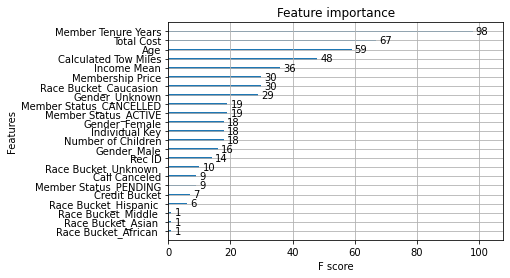

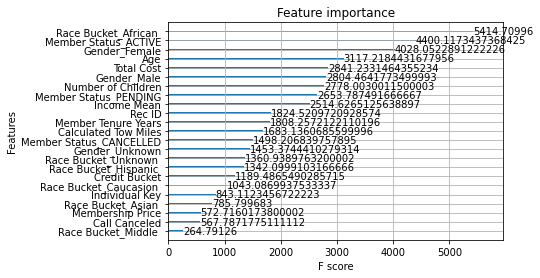

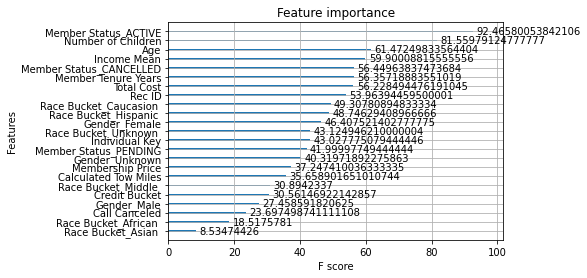

In [0]:
#Best: 0.567730 using {'alpha': 5, 'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 50, 'random_state': 13, 'scale_pos_weight': 8}
#Best: 0.964601 using {'alpha': 5, 'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 50, 'random_state': 13, 'scale_pos_weight': 100}
X_train.set_index('Household Key').columns
y_test_predict = grid_result_credit.predict(X_test.set_index('Household Key'))
print(confusion_matrix(y_true=y_test, y_pred=y_test_predict))

feat_imp=grid.best_estimator_.feature_importances_
# plot
y_test_predict

from xgboost import plot_importance
from matplotlib import pyplot

feat_imp=grid.best_estimator_.feature_importances_
# plot
#plt.bar(range(len(grid.best_estimator_.feature_importances_)), grid.best_estimator_.feature_importances_)
#plt.show()
feat_imp=pd.DataFrame(feat_imp)
feat_imp['Columns']=X_train.set_index('Household Key').columns
feat_imp.set_index('Columns', inplace=True)

plot_importance(grid.best_estimator_)
pyplot.show()

plot_importance(grid.best_estimator_, importance_type= 'cover')
pyplot.show()

plot_importance(grid.best_estimator_, importance_type= 'gain')
pyplot.show()

In [0]:
print(product_cols)
print(Household_ads['FSV ID Theft Flag'].value_counts(normalize=True))
y_new = Household_ads['FSV ID Theft Flag']
col_list=list(X_new.columns).append('FSV ID Theft Flag')
#transformed_df
X_train, X_test, y_train, y_test = train_test_split(transformed_df.reset_index(), y_new, test_size=0.2, random_state=0)

['FSV Credit Card Flag', 'FSV CMSI Flag', 'FSV Deposit Program Flag', 'FSV Home Equity Flag', 'FSV ID Theft Flag', 'TRV Globalware Flag', 'INS Client Flag']
0    0.955161
1    0.044839
Name: FSV ID Theft Flag, dtype: float64


In [0]:

params={'n_estimators': [50, 100],
 'max_depth': [4],
 'scale_pos_weight': [ 8, 20, 50],
 'alpha':[5],
 'learning_rate':[0.1],
 'random_state': [13]}
model = XGBClassifier(objective='binary:logistic', booster='gbtree', colsample_bytree= 0.3)
# define evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# define grid search
grid = GridSearchCV(estimator=model, param_grid=params, n_jobs=-1, cv=cv, scoring='recall')  
grid_result = grid.fit(X_train.set_index('Household Key'), y_train)        

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
# report all configurations
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))


Best: 0.691813 using {'alpha': 5, 'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 50, 'random_state': 13, 'scale_pos_weight': 50}
0.016374 (0.028475) with: {'alpha': 5, 'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 50, 'random_state': 13, 'scale_pos_weight': 8}
0.424269 (0.125011) with: {'alpha': 5, 'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 50, 'random_state': 13, 'scale_pos_weight': 20}
0.691813 (0.117104) with: {'alpha': 5, 'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 50, 'random_state': 13, 'scale_pos_weight': 50}
0.036257 (0.040562) with: {'alpha': 5, 'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 100, 'random_state': 13, 'scale_pos_weight': 8}
0.331579 (0.100393) with: {'alpha': 5, 'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 100, 'random_state': 13, 'scale_pos_weight': 20}
0.581092 (0.139987) with: {'alpha': 5, 'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 100, 'random_state': 13, 'scale_pos_weight': 50}


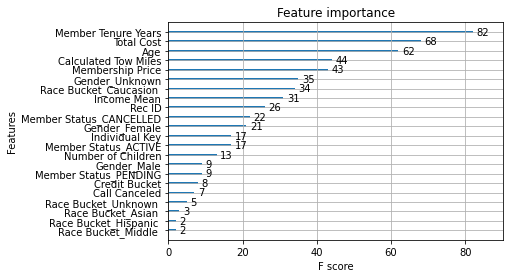

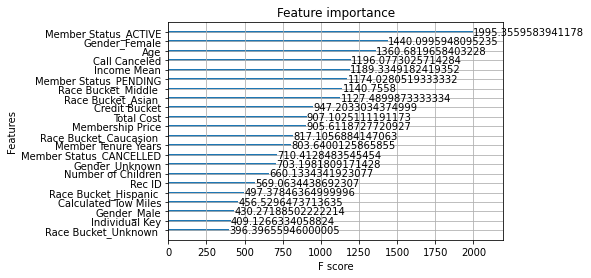

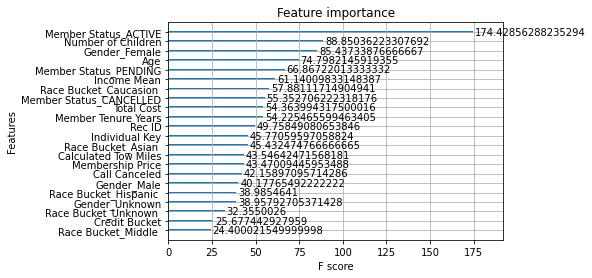

In [0]:
#0.691813 using {'alpha': 5, 'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 50, 'random_state': 13, 'scale_pos_weight': 50}
X_train.set_index('Household Key').columns
y_test_predict = grid_result.predict(X_test.set_index('Household Key'))
confusion_matrix(y_true=y_test, y_pred=y_test_predict)

feat_imp=grid.best_estimator_.feature_importances_
# plot
y_test_predict

from xgboost import plot_importance
from matplotlib import pyplot
y_test_predict = grid_result.predict(X_test.set_index('Household Key'))
confusion_matrix(y_true=y_test, y_pred=y_test_predict)

feat_imp=grid.best_estimator_.feature_importances_
# plot
#plt.bar(range(len(grid.best_estimator_.feature_importances_)), grid.best_estimator_.feature_importances_)
#plt.show()
feat_imp=pd.DataFrame(feat_imp)
feat_imp['Columns']=X_train.set_index('Household Key').columns
feat_imp.set_index('Columns', inplace=True)

plot_importance(grid.best_estimator_)
pyplot.show()

plot_importance(grid.best_estimator_, importance_type= 'cover')
pyplot.show()

plot_importance(grid.best_estimator_, importance_type= 'gain')
pyplot.show()

##Models for predicting Total cost and Total Rec ID

In [0]:
Reg_house_ads=Household_ads.set_index('Household Key')
Reg_house_ads

In [0]:
Reg_house_ads=Household_ads.set_index('Household Key')
Reg_house_ads
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PowerTransformer
pt = PowerTransformer()

X_new = Reg_house_ads.drop('Total Cost', axis=1)
y_new = Reg_house_ads['Total Cost']
transformed_df=pt.fit_transform(X_new)
transformed_df=pd.DataFrame(transformed_df, index=X_new.index, columns=X_new.columns)
#transformed_df.columns=X_new.columns
transformed_df
col_list=list(X_new.columns).append('Total Cost')
#splitting into training and test
X_train, X_test, y_train, y_test = train_test_split(transformed_df, y_new, test_size=0.2, random_state=0)

print(len(y_train))
print(len(y_test))

4192
1049


In [0]:
#building a regressor

from xgboost import XGBRegressor


params={'n_estimators': [100, 500],
 'max_depth': [4],
 'alpha':[5, 10],
 'learning_rate':[0.1],
 'random_state': [13], 
 'reg_lambda':[0.02,0.05,0.1],
 'gamma':[2,5,10]
 }
model = XGBRegressor(colsample_bytree= 0.3, importance_type='gain', verbose=0,)
# define evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# define grid search
grid = GridSearchCV(estimator=model, param_grid=params, cv=5, verbose=0)  
grid_result = grid.fit(X_train, y_train)        

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
# report all configurations
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))


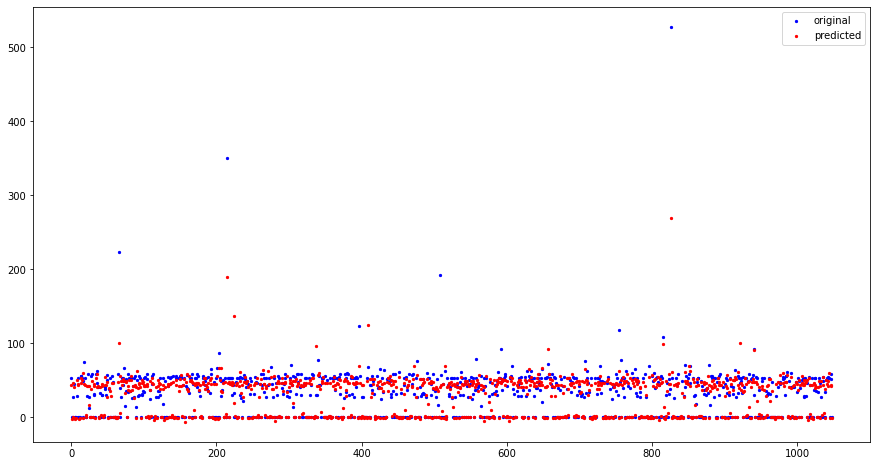

In [0]:
#Best: 0.765560 using {'alpha': 5, 'gamma': 5, 'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 500, 'random_state': 13, 'reg_lambda': 0.1}
#0.691813 using {'alpha': 5, 'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 50, 'random_state': 13, 'scale_pos_weight': 50}
#X_train.set_index('Household Key').columns
y_test_predict = grid_result.predict(X_test)
#confusion_matrix(y_true=y_test, y_pred=y_test_predict)

feat_imp=grid.best_estimator_.feature_importances_
# plot
y_test_predict

from xgboost import plot_importance
from matplotlib import pyplot
y_test_predict = grid_result.predict(X_test)
#confusion_matrix(y_true=y_test, y_pred=y_test_predict)

feat_imp=grid.best_estimator_.feature_importances_
# plot
#plt.bar(range(len(grid.best_estimator_.feature_importances_)), grid.best_estimator_.feature_importances_)
#plt.show()
feat_imp=pd.DataFrame(feat_imp)
feat_imp['Columns']=X_train.columns
feat_imp.set_index('Columns', inplace=True)

x_ax = range(len(y_test))
plt.figure(figsize=(15,8))
plt.scatter(x_ax, y_test, s=5, color="blue", label="original")
plt.scatter(x_ax, y_test_predict, s=5, color="red", label="predicted")
plt.legend()
plt.show()


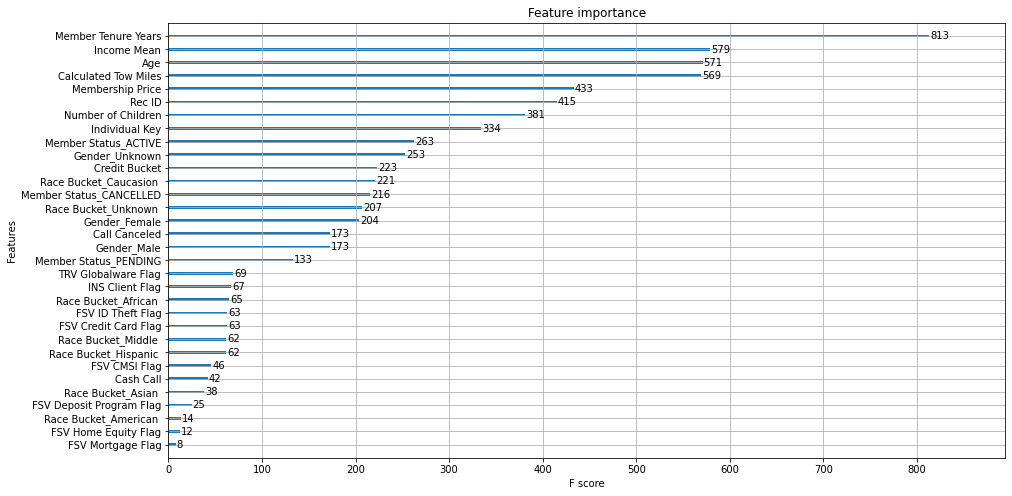

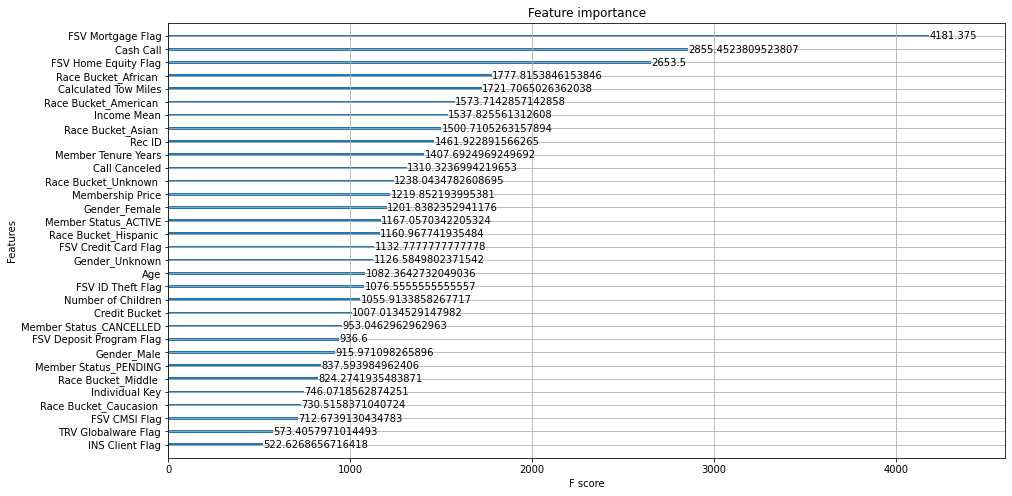

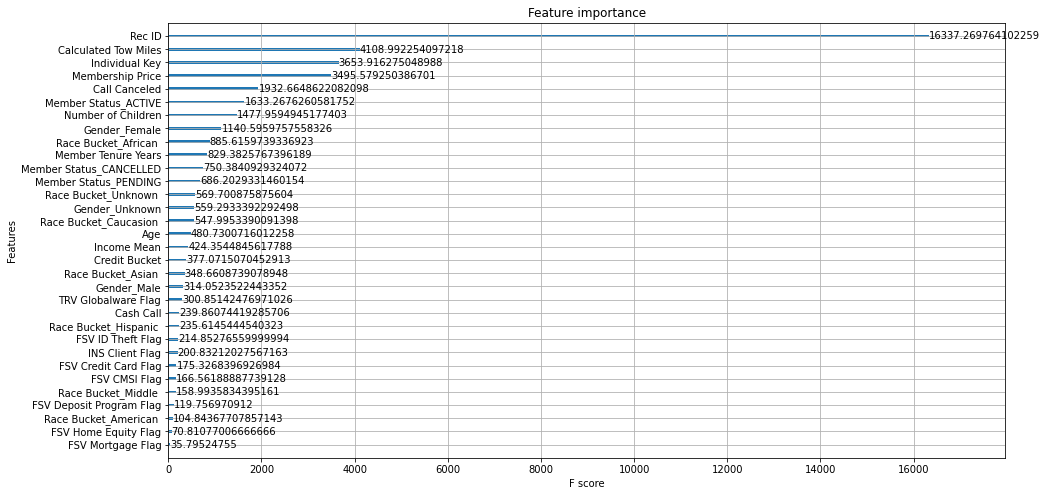

In [0]:
#ax = xgboost.plot_importance(...)

ax=plot_importance(grid.best_estimator_)
fig = ax.figure
fig.set_size_inches(15, 8)


ax2=plot_importance(grid.best_estimator_, importance_type= 'cover')
fig = ax2.figure
fig.set_size_inches(15, 8)


ax3=plot_importance(grid.best_estimator_, importance_type= 'gain')
fig = ax3.figure
fig.set_size_inches(15, 8)



In [0]:
Reg_house_ads=Household_ads.set_index('Household Key')
Reg_house_ads
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PowerTransformer
pt = PowerTransformer()

X_new = Reg_house_ads.drop('Rec ID', axis=1)
y_new = Reg_house_ads['Rec ID']
transformed_df=pt.fit_transform(X_new)
transformed_df=pd.DataFrame(transformed_df, index=X_new.index, columns=X_new.columns)
#transformed_df.columns=X_new.columns
transformed_df
col_list=list(X_new.columns).append('Rec ID')
#splitting into training and test
X_train, X_test, y_train, y_test = train_test_split(transformed_df, y_new, test_size=0.2, random_state=0)

print(len(y_train))
print(len(y_test))

4192
1049


In [0]:
params={'n_estimators': [100, 500],
 'max_depth': [4],
 'alpha':[5, 10],
 'learning_rate':[0.1],
 'random_state': [13], 
 'reg_lambda':[0.02,0.05,0.1],
 'gamma':[2,5,10]
 }
model = XGBRegressor(colsample_bytree= 0.3, importance_type='gain', verbose=0,)
# define evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# define grid search
grid = GridSearchCV(estimator=model, param_grid=params, cv=5, verbose=0)  
grid_result = grid.fit(X_train, y_train)        

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
# report all configurations
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))


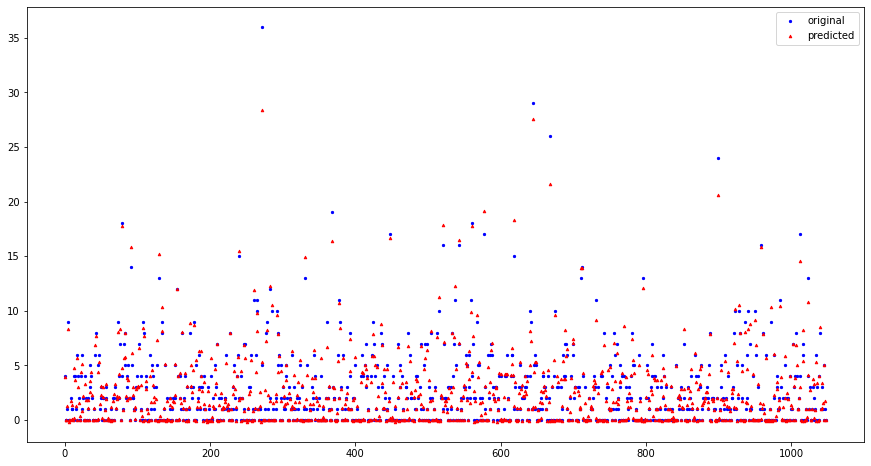

In [0]:
#Best: R2=0.822854 using {'alpha': 5, 'gamma': 2, 'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 500, 'random_state': 13, 'reg_lambda': 0.02}
#Best: 0.822854 using {'alpha': 5, 'gamma': 2, 'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 500, 'random_state': 13, 'reg_lambda': 0.02}
#X_train.set_index('Household Key').columns
y_test_predict = grid_result.predict(X_test)
#confusion_matrix(y_true=y_test, y_pred=y_test_predict)

feat_imp=grid.best_estimator_.feature_importances_
# plot
y_test_predict

from xgboost import plot_importance
from matplotlib import pyplot
y_test_predict = grid_result.predict(X_test)
#confusion_matrix(y_true=y_test, y_pred=y_test_predict)

feat_imp=grid.best_estimator_.feature_importances_
# plot
#plt.bar(range(len(grid.best_estimator_.feature_importances_)), grid.best_estimator_.feature_importances_)
#plt.show()
feat_imp=pd.DataFrame(feat_imp)
feat_imp['Columns']=X_train.columns
feat_imp.set_index('Columns', inplace=True)

x_ax = range(len(y_test))
plt.figure(figsize=(15,8))
plt.scatter(x_ax, y_test, s=5, color="blue", label="original", marker="o")
plt.scatter(x_ax, y_test_predict, s=6, color="red", label="predicted",marker="^",)
plt.legend()
plt.show()


In [0]:
#ax = xgboost.plot_importance(...)

ax=plot_importance(grid.best_estimator_)
fig = ax.figure
fig.set_size_inches(15, 8)


ax2=plot_importance(grid.best_estimator_, importance_type= 'cover')
fig = ax2.figure
fig.set_size_inches(15, 8)


ax3=plot_importance(grid.best_estimator_, importance_type= 'gain')
fig = ax3.figure
fig.set_size_inches(15, 8)


NameError: ignored

##putting everything together

In [0]:
#score flags first
#